<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;"> TFM Ciencia Datos</p>
<p style="margin: 0; text-align:right;">2024-2 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;"></p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Machine learning aplicado a la medicina personalizada

A lo largo de este trabajo se estudiarán las enfermedades del corazón de isquemia e infarto relacionadas con un DataSet de Kaagle.  
Para ello haré uso de las imagenes del corazón obtenidas mediante la técnica de perfusión miocárdica.
Para realizar la práctica utilizaré la plataforma de Keras ya que esta incorpora múltiples utilidades que facilitan el entrenamiento
de modelos.

Durante este trabajo se implementaran diversos modelos de redes neuronales para la clasificación de imagenes y la caracterización
de las mismas.

La segunda fase consiste en el estudio de diferentes modelos de clasificación:
- Modelo adhoc

In [2]:
# Importamos tensorflow
import tensorflow as tf
print("TF version   : ", tf.__version__)

# Necesitamos GPU
print("GPU available: ", tf.config.list_physical_devices('GPU'))

# keras version is 2.11.0
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.15.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Keras version   :  3.1.1


In [3]:
# Importo los elementos de keras que se utilizan con mas frecuencia
from keras.utils import image_dataset_from_directory
from keras.layers import (Input,
    GlobalAveragePooling2D, Flatten,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing,
    RandomContrast,RandomBrightness)
#from keras.callbacks import EarlyStopping
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import Concatenate
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans

from tensorflow import data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#!pip install visualkeras



In [4]:
# Importo el resto de librerias
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns


In [ ]:
# Elimino el contenido del directorio de trabajo
#folder_path = '/kaggle/working'
#remove_folder_contents(folder_path)    

## 1. Modelos de clasificación, redes convolucionales (CNN)

En esta parte el proyecto probaré diferentes modelos de clasificación; empezaré con un modelo de referencia y seguidamente iré implementando otros modelos mas actualizados.
Las redes CNN modelan bien patrones en 2 dimensiones, como son las imagenes.

En las tareas de clasificación existen 2 bloques importantes:

* **Bloque extractor de caracteríscas**: En esta parte se extraen las características de las imagenes mediantes capas convolucionales. Cuanto mas profundas son las capas mejor extraen las características y mas preparadas estan para la tarea de clasificación.
* **Clasficador**: Este bloque podrá estar formado por una capa totalmente conectada o por una capa híbrida, la salida de este bloque será la probabilidad o bien el valor  asociada a cada clase dependiendo del caso.

A l'apartat anterior, el bloc "extractor de característiques" era extremadament simple, per no dir inexistent. En aquest apartat, farem ús de capes convolucionals per poder aprendre millors abstraccions de les imatges d'entrada per tal de millorar-ne la classificació.

En este apartado utilizaré las librerias de Keras de Kaagle. Utilizaré una máquina con una GPU para reducir el tiempo de entrenamiento.


### 1.1 Creación del conjunt de datos en formato Keras/Tensorflow

Para crear una base de datos en formato Keras/Tensorflow a partir de las imagenes procesadas utilizaré la función <code>**tf.keras.utils.image_dataset_from_directory()**</code> que permite crear bases de datos a partir de imagenes dejadas en carpetas.

La documentació de esta función se encuentra en la web de [Keras](https://keras.io/api/data_loading/image/) y la de [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

In [32]:
train_data = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/spect2-mpi/SPECT_MPI2_Dataset/TrainSet",
    labels="inferred",
    label_mode="binary",
    image_size=(224, 224),        
    #image_size=(976, 897),    
    color_mode='rgb',
    shuffle=True)

val_data = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/spect2-mpi/SPECT_MPI2_Dataset/ValidationSet",
    labels="inferred",
    label_mode="binary",
    image_size=(224, 224),        
    #image_size=(976, 897),    
    interpolation='bilinear',
    color_mode='rgb',
    shuffle=True)

test_data = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/spect2-mpi/SPECT_MPI2_Dataset/TestSet",
    labels='inferred',
    label_mode='binary',        
    image_size=(224, 224),        
    #image_size=(976, 897),    
    interpolation='bilinear',
    color_mode='rgb',
    shuffle=True)


class_names = train_data.class_names
print("\nLas clases son: " + str(class_names))
print("Tipo de elementos del data set "+ str(train_data.element_spec))


Found 300 files belonging to 2 classes.
Found 32 files belonging to 2 classes.
Found 32 files belonging to 2 classes.

Las clases son: ['Abnormal', 'Normal']
Tipo de elementos del data set (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))


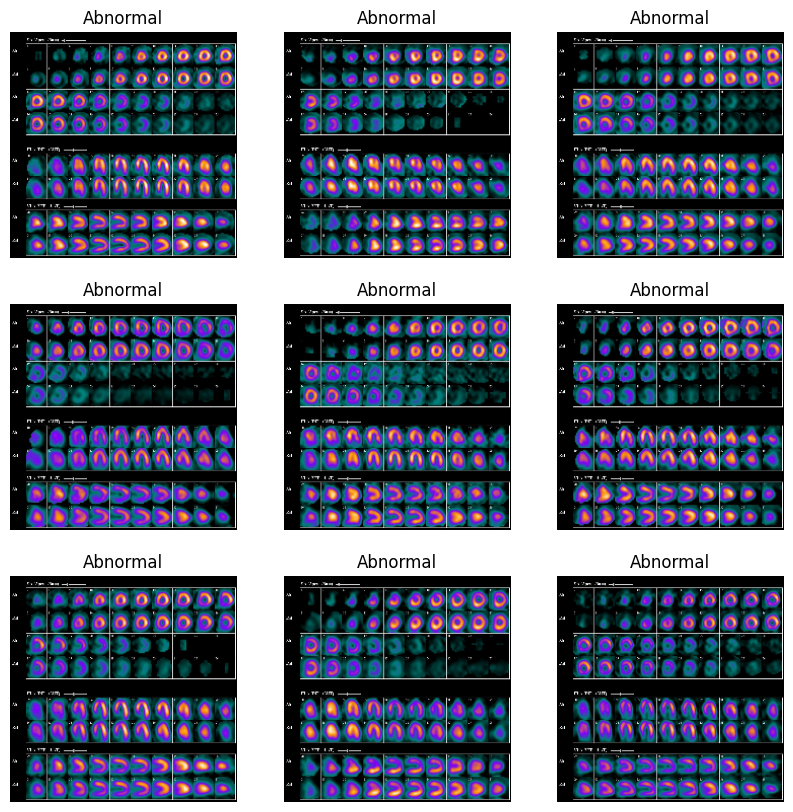

In [6]:
# Visualizo algunas de las imagenes
plt.figure(figsize=(10, 10))
for images, labels in val_data.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))        
        label = tf.argmax(labels[i]).numpy()        
        plt.title(class_names[label])
        plt.axis("off")

Creo funciones de utilidad para carga de imagenes y gráficas

In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

# Get the image from the dataset    
def getImageInfo(input_dataset):
    image_list = []
    class_list = []
    for x, y in input_dataset:
        image_list.append(x.numpy())
        class_list.append(y.numpy())        
    x_image = np.vstack(image_list)    
    y_class =np.vstack(class_list)
    return (x_image,y_class)


def plot_ROCInfo(y_test, y_pred):
    # Hago una predicción sobre los datos de test
    fp, tp, thresholds =roc_curve(y_test, y_pred)
    auc_value = auc(fp, tp)
    # Visualizo la curva ROC
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fp, tp, label='Area = {:.3f}'.format(auc_value))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    

# Plot del training loss i l'accuracy
def plot_training(n_epochs, mfit):
    N = n_epochs
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    fig.suptitle('Training Loss and Accuracy')
    
    ax1.plot(np.arange(0, N), mfit.history["accuracy"], label="train")
    ax1.plot(np.arange(0, N), mfit.history["val_accuracy"], label="val")
    ax1.set_title("Accuracy")
    ax1.set_xlabel("Epoch #")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")
    
    ax2.plot(np.arange(0, N), mfit.history["loss"], label="train")
    ax2.plot(np.arange(0, N), mfit.history["val_loss"], label="val")
    ax2.set_title("Loss")
    ax2.set_xlabel("Epoch #")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")    
    plt.show()    
    
# Plot de matriz de confusion

def plot_confusion_matrix(cm):
    ax= plt.subplot()
    group_names = ['Verdadero Positivo','Falso Positivo','Falso Negativo','Verdero Negativo']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    ax.xaxis.set_ticklabels(['Anormal(0)', 'Normal(1)']) # Valor (0,1)
    ax.yaxis.set_ticklabels(['Anormal(0)','Normal(1)'])
    plt.show()  
    
# Obtener métricas
def getScores(y_test,y_pred):
    # Calculo la matriz de confusion
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    cm = confusion_matrix(y_test, y_pred_binary)            
    # Precisión
    VP, FP, FN, VN = cm.ravel()
    accuracy =(VP+VN)/(VP+FP+FN+VN)
    precision = VP/(VP+FP)  
    recall = VP/(VP+FN)
    especif = VN/(VN+FP)
    f1 = (2*precision * recall)/(precision + recall)
    return (accuracy,precision,recall,f1)
    
    
# Metricas de las pruebas de entrenamiento    
def showMatrixMetrics(y_test, y_pred)    :
    # Calculo la matriz de confusion
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    cm = confusion_matrix(y_test, y_pred_binary)        
    
    print("Matriz de confusión:")    
    # Visualizo la gráfica
    plot_confusion_matrix(cm)

    # Precisión
    VP, FP, FN, VN = cm.ravel()
    accuracy =(VP+VN)/(VP+FP+FN+VN)
    precision = VP/(VP+FP)  
    recall = VP/(VP+FN)
    especif = VN/(VN+FP)
    f1 = (2*precision * recall)/(precision + recall)
    
    # Scores
    print("Exactitud: {:.4f}".format(accuracy))
    print("Precision:  {:.4f}".format(precision))
    print("Sensibilidad:  {:.4f}".format(recall))
    print("Especifidad:  {:.4f}".format(especif))
    print("F1 Score:  {:.4f}".format(f1))

    
# Clear output folder
import os

def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

1.2 Modelo ANN de test

In [8]:
# Definició de la xarxa
#resizeScale = 32/976;

ann_model = Sequential()
ann_model.add(Resizing(height = 32, width = 32, interpolation="bilinear", input_shape=(976,897,3)))
ann_model.add(Rescaling(1./255))
ann_model.add(Flatten())
ann_model.add(Dense(1024, activation="relu"))
ann_model.add(Dense(1, activation="sigmoid"))

ann_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,147,777 (12.01 MB)

 Trainable params: 3,147,777 (12.01 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Compilación de la red
opt = Adam(learning_rate=0.001)

ann_model.compile(
    optimizer=opt,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

stopping =  EarlyStopping(monitor='val_loss',
                            patience=15, 
                            verbose=1, 
                            restore_best_weights=True)

In [10]:
# Entrenamiento de la red
t = time.time()
ann_model.save_weights('ann_model.weights.h5')
ann_history = ann_model.fit(train_data,
                            epochs=100,                            
                            callbacks=[stopping],
                            verbose=1,
                            validation_data=val_data)
print ("Tiempo de entrenamiento: ",time.time() - t, "segundos.")


Epoch 1/100
 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4516 - loss: 1.5043

I0000 00:00:1716194606.045493      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716194606.060272      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.5276 - loss: 1.2484 - val_accuracy: 0.6875 - val_loss: 0.5928
Epoch 2/100


W0000 00:00:1716194607.332008      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9163 - loss: 0.2842 - val_accuracy: 0.7500 - val_loss: 0.5901
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9254 - loss: 0.2188 - val_accuracy: 0.6875 - val_loss: 0.6924
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9539 - loss: 0.1522 - val_accuracy: 0.6875 - val_loss: 0.7053
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9657 - loss: 0.1049 - val_accuracy: 0.7812 - val_loss: 0.8955
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9619 - loss: 0.1123 - val_accuracy: 0.7188 - val_loss: 0.7276
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9897 - loss: 0.0701 - val_accuracy: 0.6875 - val_loss: 0.7047
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9665 - loss: 0.0964 - val_accuracy: 0.6875 - val_loss: 0.7600
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9717 - loss: 0.0771 - val_accuracy: 0.7188 - val_l

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


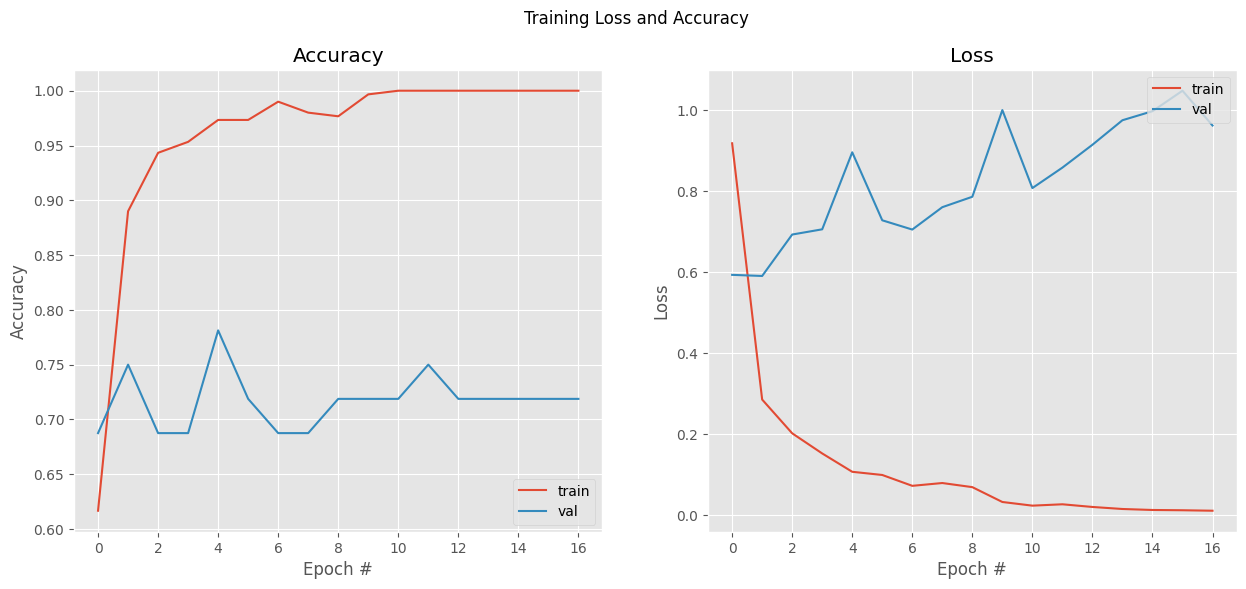

----------
Loss: 0.657941
Accuracy: 0.750000


In [11]:
ann_model.load_weights('ann_model.weights.h5')

n_epochs = len(ann_history.history["loss"])
plot_training(n_epochs, ann_history)

score = ann_model.evaluate(test_data, verbose=0)
print ("-"*10)
print ("Loss: %f"%(score[0]))
print ("Accuracy: %f"%(score[1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


W0000 00:00:1716194630.192165      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


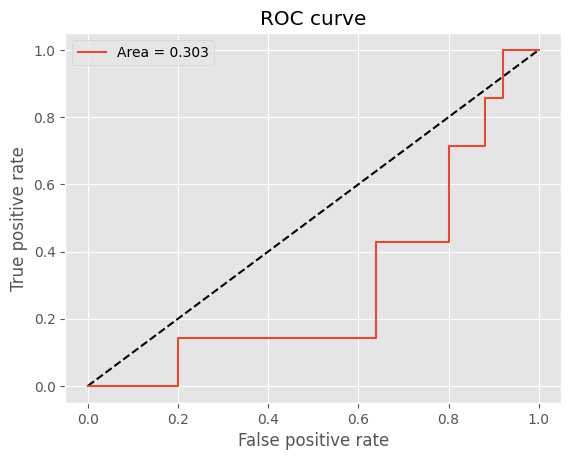

In [12]:
x_test, y_test = getImageInfo(test_data)
y_pred = ann_model.predict(x_test)
plot_ROCInfo(y_test,y_pred)


Data augmentation mediante capas de preprocesamiento de Keras

In [13]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
  layers.Input(shape=(224,224,3)),  
  #layers.Resizing(height= 39,width= 22,interpolation="bilinear"),
  layers.Rescaling(1./255)
])


# Defino la aumentación
data_augmentation = tf.keras.Sequential([  
  layers.RandomContrast(factor=0.999),      
  layers.RandomBrightness(factor = 0.001 )  
])


In [15]:
# Definició de la xarxa
ann_model2 = Sequential()
ann_model2.add(Input(shape=(224,224,3)))
ann_model2.add(resize_and_rescale)
ann_model2.add(data_augmentation)
ann_model2.add(Flatten())
ann_model2.add(Dense(1024, activation="relu"))
ann_model2.add(Dense(1, activation="sigmoid"))
ann_model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │   154,141,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,142,721 (588.01 MB)

 Trainable params: 154,142,721 (588.01 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Extraigo los elementos del dataset como un numphy array

train_data_d, train_labels_d = getImageInfo(train_data)
val_data_d, val_labels_d = getImageInfo(val_data)
test_data_d, test_labels_d = getImageInfo(test_data)
test_data_d = test_data_d.astype("uint8")

inputs = np.concatenate((train_data_d.astype("uint8") , 
                         val_data_d.astype("uint8")),
                         axis=0)
targets = np.concatenate((train_labels_d, val_labels_d), axis=0)
print("Dimensiones:")
print(inputs.shape)
print(targets.shape)
print(test_data_d.shape)


Dimensiones:
(332, 224, 224, 3)
(332, 1)
(32, 224, 224, 3)


### Ahora entreno el modelo

In [17]:
# Compilación de la red
opt2 = Adam(learning_rate=0.001)

ann_model2.compile(
    optimizer=opt2,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

stopping2 =  EarlyStopping(monitor='val_loss',
                            patience=15, 
                            verbose=1, 
                            restore_best_weights=True)

In [18]:
# Entrenamiento de la red
t = time.time()
# repitiendo registros del fichero una vez se hayan usado para un epoch
ann_history2 = ann_model2.fit(train_data,
                            epochs=100,
                            callbacks=[stopping2],
                            verbose=1,
                            validation_data=val_data)

print ("Tiempo de entrenamiento: ",time.time() - t, "segundos.")

Epoch 1/100
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5503 - loss: 43.4439

W0000 00:00:1716156813.809813      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.5698 - loss: 56.9558

W0000 00:00:1716156817.327245      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716156817.770571      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 601ms/step - accuracy: 0.5686 - loss: 56.9172 - val_accuracy: 0.2188 - val_loss: 20.2204
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.6862 - loss: 10.9200 - val_accuracy: 0.7812 - val_loss: 15.6767
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.6303 - loss: 9.3124 - val_accuracy: 0.5625 - val_loss: 6.9976
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6188 - loss: 18.3140 - val_accuracy: 0.7812 - val_loss: 23.6192
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5117 - loss: 26.9012 - val_accuracy: 0.6562 - val_loss: 7.9040
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6427 - loss: 11.0931 - val_accuracy: 0.2812 - val_loss: 44.3775
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6833 - loss: 26.4308 - val_accuracy: 0.7500 - val_loss: 13.6020
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8034 - loss: 5.5364 - val_accuracy:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


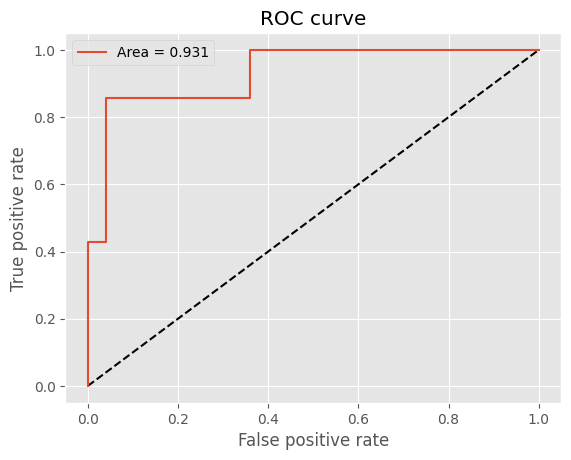

Matriz de confusión:


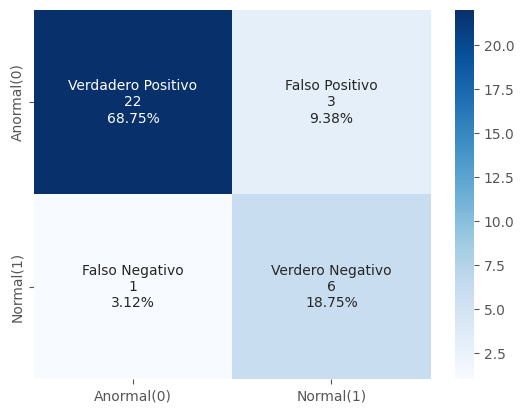

Exactitud: 0.8750
Precision:  0.8800
Sensibilidad:  0.9565
Especifidad:  0.6667
F1 Score:  0.9167


In [19]:
x_test, y_test = getImageInfo(test_data)
y_pred = ann_model2.predict(x_test)
plot_ROCInfo(y_test,y_pred)

showMatrixMetrics(y_test,y_pred)

Calculo la exactitud del modelo con un validador cruzado K-Folds estratificado.

In [20]:
# Calculo de la exactitud con un validador cruzado K-Folds estratificado.
from sklearn.model_selection import StratifiedKFold

# Entrenamiento    
callback2 =  EarlyStopping(monitor='val_loss',
                           patience=15, 
                           verbose=1, 
                           restore_best_weights=True)

# Compilación de la red
opt2 = Adam(learning_rate=0.001)

ann_model2.compile(
    optimizer=opt2,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Validador cruzado
hist_ann_model2 = []
scoreList = []

# KFold
kfold = StratifiedKFold(n_splits=10, shuffle=True)
for train_index, val_index in kfold.split(inputs,targets):        
    
    X_train_fold = inputs[train_index]
    y_train_fold = targets[train_index]
    
    X_val_fold = inputs[val_index] 
    y_val_fold = targets[val_index] 
      
    history_now = ann_model2.fit(x= X_train_fold, y= y_train_fold,                               
                              validation_data = (X_val_fold,y_val_fold),
                              batch_size=16,
                              verbose=0, 
                              epochs=100,
                              callbacks=[callback2]) 
    hist_ann_model2.append(history_now)    
    scores = ann_model2.evaluate(test_data_d,test_labels_d,verbose=0)        
    scoreList.append(scores)
    
    print ("-"*10)
    print ("Loss: %f"%(scores[0]))
    print ("Accuracy: %f"%(scores[1]))
    print(scores)

W0000 00:00:1716156921.260068      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716156925.111633      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716156925.552871      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 4.


W0000 00:00:1716156944.692591      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


----------
Loss: 0.870729
Accuracy: 0.843750
[0.8707285523414612, 0.84375]
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
----------
Loss: 0.351224
Accuracy: 0.843750
[0.35122427344322205, 0.84375]


W0000 00:00:1716156962.222567      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
----------
Loss: 2.895015
Accuracy: 0.781250
[2.895014524459839, 0.78125]
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
----------
Loss: 2.840315
Accuracy: 0.781250
[2.8403148651123047, 0.78125]
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
----------
Loss: 0.743544
Accuracy: 0.843750
[0.7435436248779297, 0.84375]
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
----------
Loss: 1.422243
Accuracy: 0.625000
[1.4222434759140015, 0.625]
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
----------
Loss: 1.230634
Accuracy: 0.687500
[1.2306338548660278, 0.6875]
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
----------
Loss: 0.236119
Accuracy: 0.906250
[0.23611876368522644, 0.90625]
Epoch 15: early stopping
Restoring model weights 

In [21]:
# Muestro resultado

from statistics import mean, stdev
import math 
    
scoresTot =  np.array(scoreList)

acc_List = scoresTot[:,1].tolist()
loss_List = scoresTot[:,0]
numRec = targets.shape[0]

mean_Acc = mean(acc_List)
std_dev_Acc = stdev(acc_List)
# Error con un 95% de fiabilidad
error = 1.96 * std_dev_Acc/ math.sqrt(numRec)
 

print('Lista de exactitudes:',acc_List)
print('\n Máxima exactitud obtenida para este modelo:',
      max(acc_List)*100, '%')
print('\n Mínima exactitud obtenida:',
      min(acc_List)*100, '%')
print('\n Exactitud media:',
      round(mean(acc_List)*100,2), '%')
print('\n La desviación estandar es:', round(stdev(acc_List),3))
print('\n Margen de error con un nivel de confianza del 95%: ' + str(round(error*100,3)))


Lista de exactitudes: [0.84375, 0.84375, 0.78125, 0.78125, 0.84375, 0.625, 0.6875, 0.90625, 0.84375, 0.875]

 Máxima exactitud obtenida para este modelo: 90.625 %

 Mínima exactitud obtenida: 62.5 %

 Exactitud media: 80.31 %

 La desviación estandar es: 0.087

 Margen de error con un nivel de confianza del 95%: 0.938


Veo que el problema se encuentra en los datos de validación, estos estan desbalanceados; voy a intentar balancear   
estos datos para mejorar el resultado.  

Dimensiones:
(332, 224, 224, 3)
(332, 1)
(32, 224, 224, 3)


Text(0.5, 1.0, 'Imagen ')

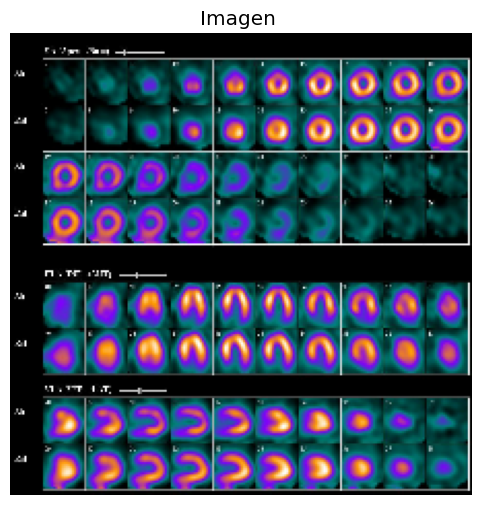

In [83]:
# Extraigo los elementos del dataset como un numphy array

train_data_d, train_labels_d = getImageInfo(train_data)
val_data_d, val_labels_d = getImageInfo(val_data)
test_data_d, test_labels_d = getImageInfo(test_data)
test_data_d = test_data_d.astype("uint8")

inputs = np.concatenate((train_data_d.astype("uint8") , 
                         val_data_d.astype("uint8")),
                         axis=0)
targets = np.concatenate((train_labels_d, val_labels_d), axis=0)
print("Dimensiones:")
print(inputs.shape)
print(targets.shape)
print(test_data_d.shape)

# Visualizo imagen 
plt.figure(figsize=(6, 6))
plt.imshow(test_data_d[0])        
plt.axis("off")
plt.title("Imagen ")


In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.Input(shape=(224,224,3)),  
  #layers.Resizing(height= 39,width= 22,interpolation="bilinear"),
  layers.Rescaling(1./255)
])


# Defino la aumentación
data_augmentation = tf.keras.Sequential([  
  layers.RandomContrast(factor=0.999),      
  layers.RandomBrightness(factor = 0.001 )  
])


In [29]:
#Se cargan las librerias necesarias
from sklearn.model_selection import StratifiedKFold

# Se aplica la técnica de KFold estratificado en el entrenamiento

def ann_model3():
    ann_model3 = Sequential()
    ann_model3.add(Input(shape=(224,224,3)))
    ann_model3.add(resize_and_rescale)
    ann_model3.add(data_augmentation)
    ann_model3.add(Flatten())
    ann_model3.add(Dense(1024, activation="relu"))
    ann_model3.add(Dense(1, activation="sigmoid"))
    # Compilación del modelo
    ann_model3.compile(optimizer=Adam(learning_rate=0.001),                       
                       loss="binary_crossentropy",
                       metrics=["accuracy"])       
    return ann_model3


model_history3 = []     
scoreList =[]
# Model
ann_model3 = ann_model3()    
# Entrenamiento    
callback3 =  EarlyStopping(monitor='val_loss',
                           patience=15, 
                           verbose=1, 
                           restore_best_weights=True)

# KFold
kfold = StratifiedKFold(n_splits=10, shuffle=True)
for train_index, val_index in kfold.split(inputs,targets):        
    
    X_train_fold = inputs[train_index]
    y_train_fold = targets[train_index]
    
    X_val_fold = inputs[val_index] 
    y_val_fold = targets[val_index] 
      
    history_now = ann_model3.fit(x= X_train_fold, y= y_train_fold,                               
                              validation_data = (X_val_fold,y_val_fold),
                              batch_size=16,
                              verbose=0, 
                              epochs=100,
                              callbacks=[callback3]) 
    model_history3.append(history_now)    
    scores = ann_model3.evaluate(test_data_d,test_labels_d,verbose=0)        
    scoreList.append(scores)
    
    print ("-"*10)
    print ("Loss: %f"%(scores[0]))
    print ("Accuracy: %f"%(scores[1]))
    print(scores)
    
    # Show metrics
    #showMatrixMetrics(test_data,scores)    
    # Muestro resultado
    
    #print ("Accuracy: %f"%(scores[1]))                        
    # Curva ROC
    #x_test, y_test = getImageInfo(test_data)
    #y_pred = ann_model3.predict(x_test)
    #plot_ROCInfo(y_test,y_pred)    
    

W0000 00:00:1716157522.245346      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716157525.350423      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716157525.708918      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 51: early stopping
Restoring model weights from the end of the best epoch: 36.


W0000 00:00:1716157571.595213      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


----------
Loss: 0.246998
Accuracy: 0.875000
[0.24699766933918, 0.875]
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
----------
Loss: 0.089165
Accuracy: 0.937500
[0.08916546404361725, 0.9375]


W0000 00:00:1716157588.226756      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 9.
----------
Loss: 0.114676
Accuracy: 0.937500
[0.11467605084180832, 0.9375]
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 1.
----------
Loss: 0.417861
Accuracy: 0.875000
[0.41786128282546997, 0.875]
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
----------
Loss: 0.256943
Accuracy: 0.875000
[0.25694262981414795, 0.875]
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
----------
Loss: 1.670744
Accuracy: 0.781250
[1.6707442998886108, 0.78125]
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
----------
Loss: 2.084740
Accuracy: 0.781250
[2.084739923477173, 0.78125]
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
----------
Loss: 0.990608
Accuracy: 0.812500
[0.990608274936676, 0.8125]
Epoch 15: early stopping
Restoring model weights fr

In [31]:
# Muestro resultado

from statistics import mean, stdev
import math 
    
scoresTot =  np.array(scoreList)

acc_List = scoresTot[:,1].tolist()
loss_List = scoresTot[:,0]
numRec = targets.shape[0]

mean_Acc = mean(acc_List)
std_dev_Acc = stdev(acc_List)
# Error con un 95% de fiabilidad
error = 1.96 * std_dev_Acc/ math.sqrt(numRec)
 
print('Lista de exactitudes:',acc_List)
print('\n Máxima exactitud obtenida para este modelo:',
      max(acc_List)*100, '%')
print('\n Mínima exactitud obtenida:',
      min(acc_List)*100, '%')
print('\n Exactitud media:',
      round(mean(acc_List)*100,2), '%')
print('\n La desviación estandar es:', round(stdev(acc_List),3))
print('\n Margen de error con un nivel de confianza del 95%: ' + str(round(error*100,3)))


Lista de exactitudes: [0.875, 0.9375, 0.9375, 0.875, 0.875, 0.78125, 0.78125, 0.8125, 0.875, 0.8125]

 Máxima exactitud obtenida para este modelo: 93.75 %

 Mínima exactitud obtenida: 78.125 %

 Exactitud media: 85.62 %

 La desviación estandar es: 0.057

 Margen de error con un nivel de confianza del 95%: 0.618


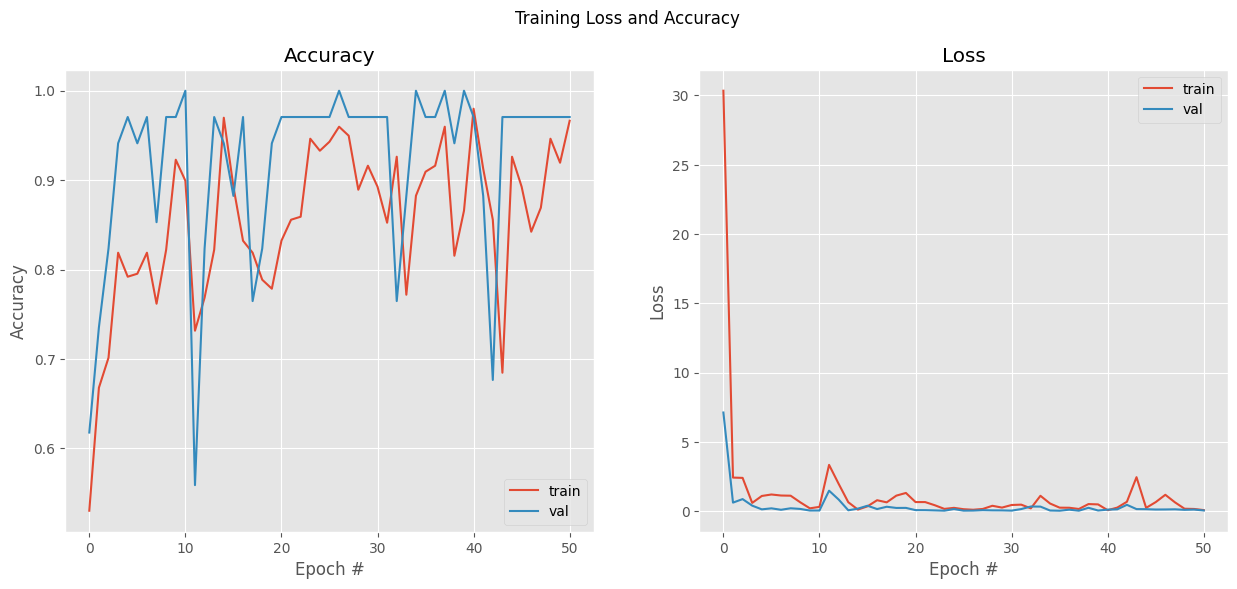

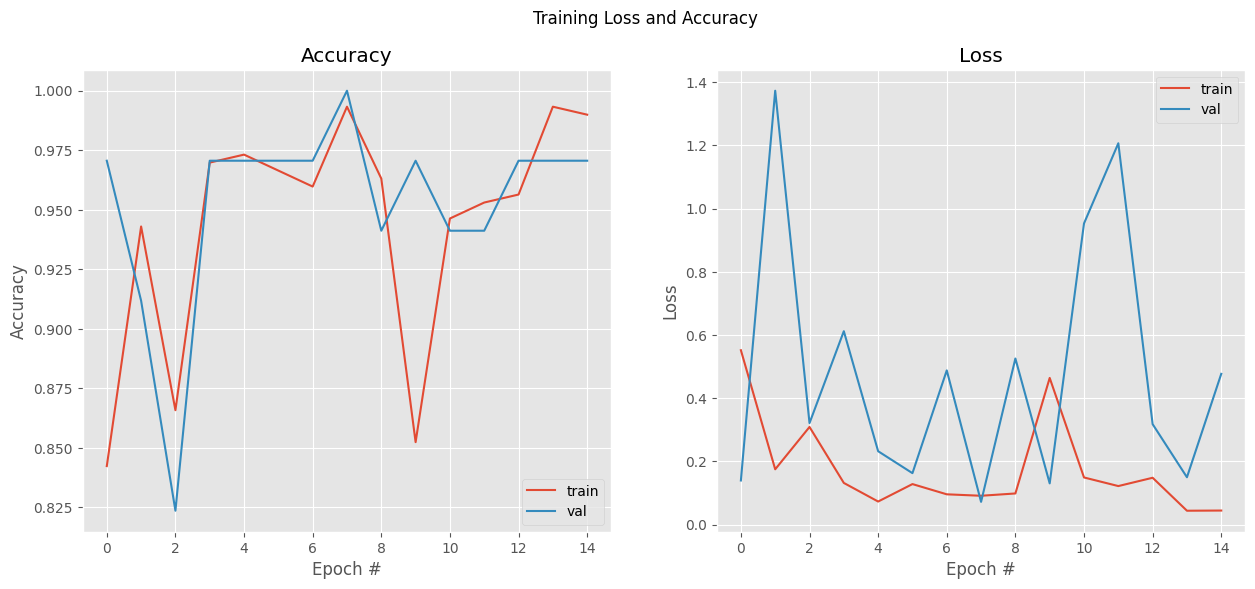

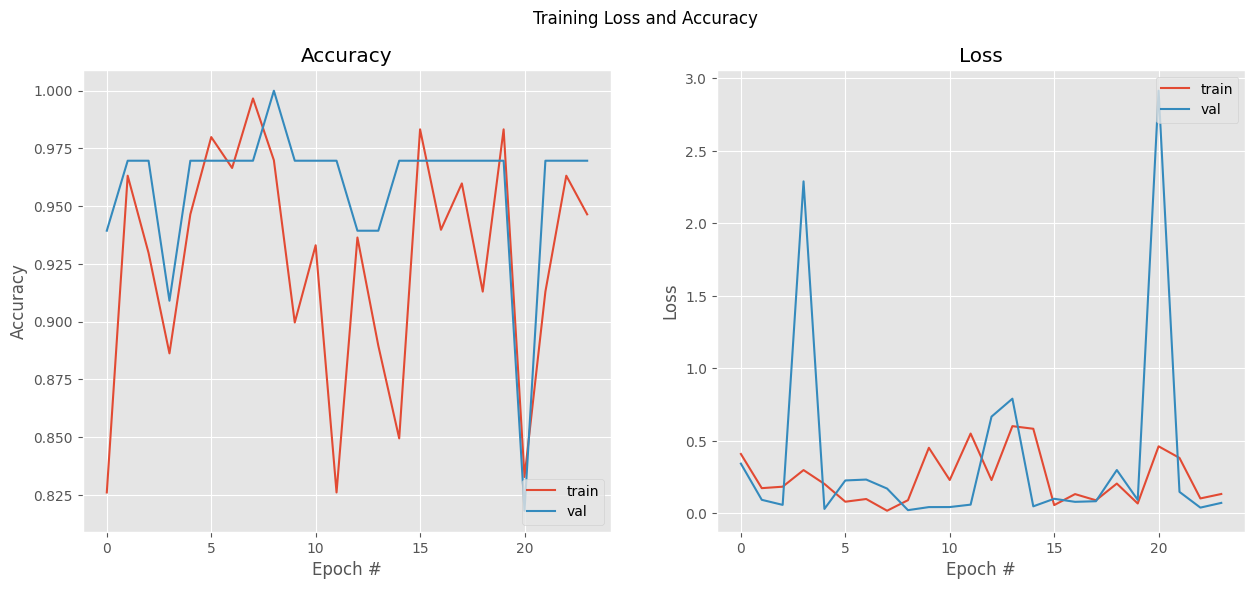

In [32]:
#  Variación de la exactitud
n_epochs = len(model_history3[0].history["loss"])
plot_training(n_epochs, model_history3[0])

n_epochs = len(model_history3[1].history["loss"])
plot_training(n_epochs, model_history3[1])

n_epochs = len(model_history3[2].history["loss"])
plot_training(n_epochs, model_history3[2])



## 2.1  Modelo RGB-CNN de referencia

Este modelo intenta replicar el modelo publicado por Nikolaos para la clasificación de imágenes de perfusión miocárdica (MPI) obtenidas mediante SPECT (Single Photon Emission Computed Tomography).


In [9]:
# Definición del modelo 

# Defino la aumentación
data_augmentation2 = tf.keras.Sequential([      
  tf.keras.layers.RandomFlip("horizontal"), 
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(factor=0.2),          
  tf.keras.layers.RandomBrightness(factor = 0.2)  
])


def cnn_model():
    initializer = keras.initializers.HeNormal()
    
    # Bloque extractor    
    input1 = keras.Input(shape=(224,224,3), name="image")    
    augment = data_augmentation2(input1)     
    # Resize    
    resize = Resizing(height= 224,width= 224,interpolation="bilinear",
                      crop_to_aspect_ratio=False)(augment)

    # Reescalado
    scaling2 = Rescaling(1./255,offset=0.0) (resize)

    # Convoluciones
    conv1 = Conv2D(16,(3, 3),activation="relu", padding="same",
                   kernel_initializer=initializer)(scaling2)
    maxp1 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv1)
    drop1 = Dropout(.1, noise_shape=None, seed=None)(maxp1)
    
    batNorm1 = BatchNormalization() (drop1)

    conv2 = Conv2D(32,(3, 3),activation="relu", padding="same",
                   kernel_initializer=initializer)(batNorm1)
    maxp2 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv2)
    drop2 = Dropout(.1, noise_shape=None, seed=None)(maxp2)
    
    batNorm2 = BatchNormalization() (drop2)

    conv3 = Conv2D(64,(3, 3),activation="relu", padding="same",
                   kernel_initializer=initializer)(batNorm2)
    maxp3 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv3)
    drop3 = Dropout(.1, noise_shape=None, seed=None)(maxp3)
    
    batNorm3 = BatchNormalization() (drop3)

    conv4 = Conv2D(128,(3, 3),activation="relu", padding="same",                   
                   kernel_initializer=initializer)(batNorm3)
    maxp4 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv4)
    drop4 = Dropout(.1, noise_shape=None, seed=None)(maxp4)

    # Capa de flatten per convertir la imagen en un vector
    flaten1 = Flatten() (drop4)

    # Capa connectada a 128 neuronas y activación ReLU
    # Añado un regularizador pues es la capa que presenta mas parámetros
    dense1 = Dense(128, activation='relu',
                   kernel_regularizer =tf.keras.regularizers.l1(0.01),
                   kernel_initializer=initializer)(flaten1)

    ##drop5 = Dropout(.1, noise_shape=None, seed=None)(dense1)

    # Capa concetada a 128 neuronas y activación ReLU
    dense2 = Dense(128,activation='relu',
                   kernel_initializer=initializer)(dense1)

    # Capa de clasificación
    dense3 = Dense(1, activation='sigmoid')(dense2)

    model_func = Model(inputs=input1, outputs=dense3, name="RGB-CNN")    
    
    return model_func
    
model_func = cnn_model();   
model_func.summary()
    

Model: "RGB-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 3,325,921 (12.69 MB)

 Trainable params: 3,325,697 (12.69 MB)

 Non-trainable params: 224 (896.00 B)

### Optimización de hiperparámetros.

In [86]:
import keras_tuner as kt

class cnn_hyperModel(kt.HyperModel):
    def build(self, hp):
        # definir una función para entrenar el modelo
        model_created = cnn_model()
        # Compilación 
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
        model_created.compile(optimizer=Adam(learning_rate=hp_learning_rate),                    
                              loss="binary_crossentropy",                      
                              metrics=["accuracy"])        
        return model_created

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [8, 16, 32]),
            **kwargs,
        )
    
    
cnn_hyperModel(kt.HyperParameters())    
tuner = kt.Hyperband(cnn_hyperModel(),
                     objective='accuracy',
                     max_epochs=300,
                     factor=3,
                     overwrite=True,
                     directory='/kaggle/working/',
                     project_name='CNN Best model')


# Control de mejora en la validación
callback =  EarlyStopping(monitor='val_loss',
                          patience=40, 
                          verbose=1, 
                          restore_best_weights=True)


tuner.search(train_data, epochs=300, validation_data=val_data,callbacks=[callback])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
  

Trial 9 Complete [00h 00m 07s]
accuracy: 0.6033333539962769

Best accuracy So Far: 0.6466666460037231
Total elapsed time: 00h 01m 06s


In [85]:
best_batch_size= best_hps.get('batch_size')
best_learning_rate = best_hps.get('learning_rate')

print('batch_size:', best_batch_size)
print('learning_rate:', best_learning_rate)

batch_size: 32
learning_rate: 0.0001


Para el entrenamiento cojo la mejor configuración anterior. 

In [87]:
# definir una función para entrenar el modelo
model_created = cnn_model()
# Compilación 
model_created.compile(optimizer=Adam(learning_rate=0.0001),                    
                      loss="binary_crossentropy",                      
                      metrics=["accuracy"])

# Defino un nuevo tipo de control
#callback2 = ReduceLROnPlateau(monitor='loss',patience=5)

# Control de mejora en la validación
callback =  EarlyStopping(monitor='val_loss',
                          patience=15, 
                          verbose=1, 
                          restore_best_weights=True)
# Entrenamiento
history = model_created.fit(train_data, 
                        epochs=140,                        
                        batch_size=32, 
                        callbacks=[callback], 
                        #callbacks=[callback,callback2], 
                        validation_data=val_data)    


Epoch 1/140


2024-05-23 18:09:26.882640: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/RGB-CNN_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.5442 - loss: 233.9335 - val_accuracy: 0.7812 - val_loss: 219.6286
Epoch 2/140
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6646 - loss: 214.9266 - val_accuracy: 0.7812 - val_loss: 200.3040
Epoch 3/140
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6738 - loss: 195.4666 - val_accuracy: 0.6250 - val_loss: 180.9081
Epoch 4/140
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6849 - loss: 176.0956 - val_accuracy: 0.2500 - val_loss: 162.0785
Epoch 5/140
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7606 - loss: 157.4020 - val_accuracy: 0.2188 - val_loss: 144.6033
Epoch 6/140
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6941 - loss: 139.8786 - val_accuracy: 0.2188 - val_loss: 128.3737
Epoch 7/140
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6910 - loss: 123.6349 - val_accuracy: 0.2188 - val_loss: 112.8725
Epoch 8/140
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6895 - loss: 108.5646

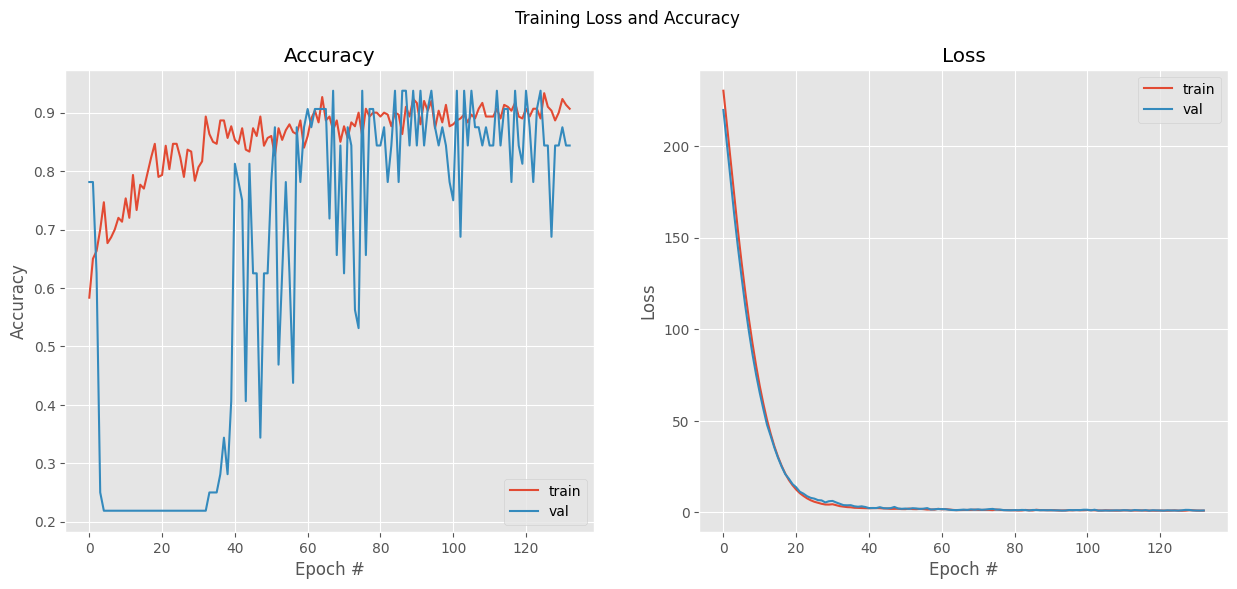

In [88]:
# Muestro los resultados  
plot_training(133,history)  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


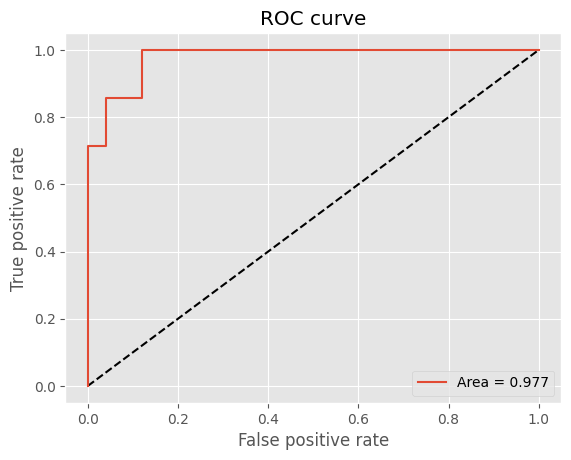

Matriz de confusión:


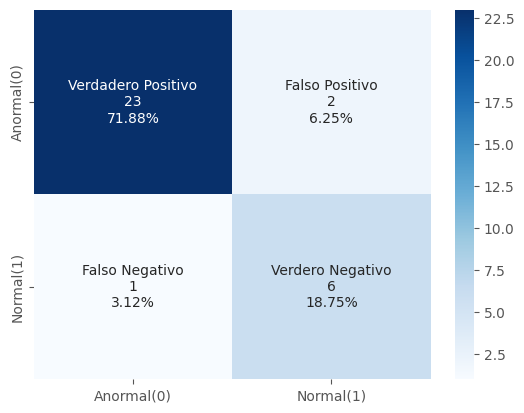

Exactitud: 0.9062
Precision:  0.9200
Sensibilidad:  0.9583
Especifidad:  0.7500
F1 Score:  0.9388


In [89]:
# Curva ROC
x_test, y_test = getImageInfo(test_data)
y_pred = model_created.predict(x_test)
plot_ROCInfo(y_test,y_pred)

# Muestro los datos de la matriz de confusion
showMatrixMetrics(y_test,y_pred)


### Evaluación de la exactitud mediante la validación K-Fold estratificada

In [91]:
#Se cargan las librerias necesarias
from sklearn.model_selection import StratifiedKFold

scoreList_RGB =[]
hist_RGB =[]

# KFold
kfold = StratifiedKFold(n_splits=10, shuffle=True)
for train_index, val_index in kfold.split(inputs,targets):        
    
    X_train_fold = inputs[train_index]
    y_train_fold = targets[train_index]
    
    X_val_fold = inputs[val_index] 
    y_val_fold = targets[val_index] 
    
    # Entrenamiento    
    callback1 =  EarlyStopping(monitor='val_loss',
                           patience=15, 
                           verbose=1, 
                           restore_best_weights=True)
    # Defino un nuevo tipo de control
    callback2 = ReduceLROnPlateau(monitor='loss',patience=5)
    
    # Compilación 
    model_created.compile(optimizer=Adam(learning_rate=0.0001),                    
                      loss="binary_crossentropy",                      
                      metrics=["accuracy"])
      
    history_now = model_created.fit(x= X_train_fold, y= y_train_fold,                               
                                   validation_data = (X_val_fold,y_val_fold),
                                   batch_size=32,
                                   verbose=0, 
                                   epochs=140,
                                   callbacks=[callback1]) 
                                   #callbacks=[callback1, callback2]) 
    hist_RGB.append(history_now)    
    scores = model_created.evaluate(test_data_d,test_labels_d,verbose=0)        
    scoreList_RGB.append(scores)
    
    print ("-"*10)
    print ("Loss: %f"%(scores[0]))
    print ("Accuracy: %f"%(scores[1]))
    print(scores)

Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 22.
----------
Loss: 4.033345
Accuracy: 0.906250
[4.0333452224731445, 0.90625]


2024-05-23 18:14:09.292995: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/RGB-CNN_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 54: early stopping
Restoring model weights from the end of the best epoch: 39.
----------
Loss: 3.821398
Accuracy: 0.906250
[3.8213982582092285, 0.90625]
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 12.
----------
Loss: 3.550194
Accuracy: 0.906250
[3.5501935482025146, 0.90625]
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 10.
----------
Loss: 3.357219
Accuracy: 0.937500
[3.3572187423706055, 0.9375]


2024-05-23 18:15:23.312319: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/RGB-CNN_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 10.
----------
Loss: 3.272048
Accuracy: 0.937500
[3.2720484733581543, 0.9375]
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 8.
----------
Loss: 3.216250
Accuracy: 0.937500
[3.21625018119812, 0.9375]
Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 26.
----------
Loss: 3.083709
Accuracy: 0.906250
[3.0837085247039795, 0.90625]


2024-05-23 18:16:26.500280: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/RGB-CNN_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 26.
----------
Loss: 2.716698
Accuracy: 0.906250
[2.716698408126831, 0.90625]
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 10.
----------
Loss: 2.853612
Accuracy: 0.937500
[2.8536124229431152, 0.9375]
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 8.
----------
Loss: 2.676605
Accuracy: 0.937500
[2.676604747772217, 0.9375]


In [92]:
# Muestro resultado

from statistics import mean, stdev
import math 
    
scoresTot =  np.array(scoreList_RGB)

acc_List = scoresTot[:,1].tolist()
loss_List = scoresTot[:,0]
numRec = targets.shape[0]

mean_Acc = mean(acc_List)
std_dev_Acc = stdev(acc_List)
# Error con un 95% de fiabilidad
error = 1.96 * std_dev_Acc/ math.sqrt(numRec)
 
print('Lista de exactitudes:',acc_List)
print('\n Máxima exactitud obtenida para este modelo:',
      max(acc_List)*100, '%')
print('\n Mínima exactitud obtenida:',
      min(acc_List)*100, '%')
print('\n Exactitud media:',
      round(mean(acc_List)*100,2), '%')
print('\n La desviación estandar es:', round(stdev(acc_List),3))
print('\n Margen de error con un nivel de confianza del 95%: ' + str(round(error*100,3)))


Lista de exactitudes: [0.90625, 0.90625, 0.90625, 0.9375, 0.9375, 0.9375, 0.90625, 0.90625, 0.9375, 0.9375]

 Máxima exactitud obtenida para este modelo: 93.75 %

 Mínima exactitud obtenida: 90.625 %

 Exactitud media: 92.19 %

 La desviación estandar es: 0.016

 Margen de error con un nivel de confianza del 95%: 0.177


## 2.1  Modelo RGB-CNN con variable característica extra       

Lo primer a hacer es cargar las imagenes en un array para ser usadas posteriormente.
Habrá tres fuentes de dato que se introducira en el modelo:  
* Imagenes : formato RGB
* Sexo: Valor 1 si masculino, valor cero si femenino
* Labels de clasificación: valor 1 si anormal, valor 1 si anormal

In [33]:
from PIL import Image
import random

# Function that reads the csv file of images
def getImageList(ImgInfFile, ImgDir):         
    # Read csv file with sex information            
    df_imageInf = pd.read_excel(ImgInfFile)            
    # Rename fields
    df_imageInf.rename(columns = {'# Patients':'idPatImg'}, inplace = True)
    # Delete las 3 registers
    df_imageInf.drop(df_imageInf.tail(3).index,inplace=True)
    # Set format
    df_imageInf['idPatImg'] = df_imageInf['idPatImg'].astype("string")
    df_imageInf['idPatImg'].str.strip()
    df_imageInf['Sex'] = df_imageInf['Sex'].astype("string")    
    df_imageInf['Sex'] = df_imageInf['Sex'].str.strip()    
    # Select valid states
    Statelist = {"Abnormal":0, "Normal":1}    
    # Set output list
    imageList = []  # RGB image
    sexList = []    # Male: 1, Female 0
    labelList = []  # AbNormal: 1, Normal: 0
    ##
    dir_list  = os.scandir(ImgDir)
    for entry in dir_list:         
        # Search in especific subdirectories 
        bProcess = False
        subdirName = ""
        if (os.path.isdir(entry)):
            subdirName = os.path.basename(os.path.normpath(entry))            
            if (subdirName in Statelist):
                bProcess = True
            else: 
                bProcess = False                
        # Process        
        if (bProcess):            
            print("Read " + str(entry.path))
            fileList_order = glob.glob(os.path.join(entry.path, "*.jpg"))                                    
            fileList = random.sample(fileList_order,len(fileList_order))
            print(type(fileList))
            if (len(fileList) >0):                
                for file_path in fileList:
                    # Add image                    
                    #img = cv2.imread(file_path, cv2.IMREAD_COLOR)                    
                    img = Image.open(file_path)
                    imageList.append(img)                    
                    # Get the name and search sex information
                    file_name = os.path.basename(file_path)
                    fileSplit = os.path.splitext(file_name)                    
                    # Add sex of patients                     
                    fileHead = fileSplit[0].strip()                    
                    # Get patient header
                    patHead = fileHead.split("_")[0]                    
                    sex = df_imageInf.loc[df_imageInf['idPatImg'] == patHead,'Sex'].item()                                         
                    # Set Male to number 1 and Female to 0 ; if not found default is female
                    # One shot encondig
                    if (sex == "M"):
                        sexNum = np.array([1,0])                        
                    else:
                        if (sex == "F"):
                            sexNum = np.array([0,1])                                                
                        else: 
                            sexNum = np.array([0,0])
                    sexList.append(sexNum)
                    # Set Label
                    label = Statelist[subdirName]
                    labelList.append(label)
                     
                    #print("Fichero " + file_name + ","+ str(sex) + ","+ str(label))
                    #print(sexNum)
                    
                    
    # Convert imageList to array                
    imageArr = np.array(imageList)
    sexArr = np.array(sexList)
    labelArr = np.array(labelList).reshape(len(labelList))
    # Return the value
    return (imageArr,sexArr,labelArr)                
    

In [75]:
# Read the images array and sex
ImgInfFile = "/kaggle/input/spect2-mpi/SPECT_MPI2_Dataset/GroundTruth.xlsx"

print("\n ->Datos de entrenamiento: \n ") 

ImgDir = "/kaggle/input/spect2-mpi/SPECT_MPI2_Dataset/TrainSet"
X_Input1_train,X_Input2_train, y_train = getImageList(ImgInfFile,ImgDir)

print("Tamaño imagenes " + str(X_Input1_train.shape))
print("Tamaño inf. sexo " + str(X_Input2_train.shape))
print("Tamaño inf. labels " + str(y_train.shape))

# Validation set
print("\n ->Datos de validación: \n") 

ImgDir = "/kaggle/input/spect2-mpi/SPECT_MPI2_Dataset/ValidationSet"
X_Input1_val,X_Input2_val, y_val = getImageList(ImgInfFile,ImgDir)

print("Tamaño imagenes " + str(X_Input1_val.shape))
print("Tamaño inf. sexo " + str(X_Input2_val.shape))
print("Tamaño inf. labels " + str(y_val.shape))

# Test set
print("\n ->Datos de test: \n") 

ImgDir = "/kaggle/input/spect2-mpi/SPECT_MPI2_Dataset/TestSet"
X_Input1_test,X_Input2_test, y_test = getImageList(ImgInfFile,ImgDir)

print("Tamaño imagenes " + str(X_Input1_test.shape))
print("Tamaño inf. sexo " + str(X_Input2_test.shape))
print("Tamaño inf. labels " + str(y_test.shape))




 ->Datos de entrenamiento: 
 
Read /kaggle/input/spect2-mpi/SPECT_MPI2_Dataset/TrainSet/Normal
<class 'list'>
Read /kaggle/input/spect2-mpi/SPECT_MPI2_Dataset/TrainSet/Abnormal
<class 'list'>
Tamaño imagenes (300, 897, 976, 3)
Tamaño inf. sexo (300, 2)
Tamaño inf. labels (300,)

 ->Datos de validación: 

Read /kaggle/input/spect2-mpi/SPECT_MPI2_Dataset/ValidationSet/Normal
<class 'list'>
Read /kaggle/input/spect2-mpi/SPECT_MPI2_Dataset/ValidationSet/Abnormal
<class 'list'>
Tamaño imagenes (32, 897, 976, 3)
Tamaño inf. sexo (32, 2)
Tamaño inf. labels (32,)

 ->Datos de test: 

Read /kaggle/input/spect2-mpi/SPECT_MPI2_Dataset/TestSet/Normal
<class 'list'>
Read /kaggle/input/spect2-mpi/SPECT_MPI2_Dataset/TestSet/Abnormal
<class 'list'>
Tamaño imagenes (32, 897, 976, 3)
Tamaño inf. sexo (32, 2)
Tamaño inf. labels (32,)


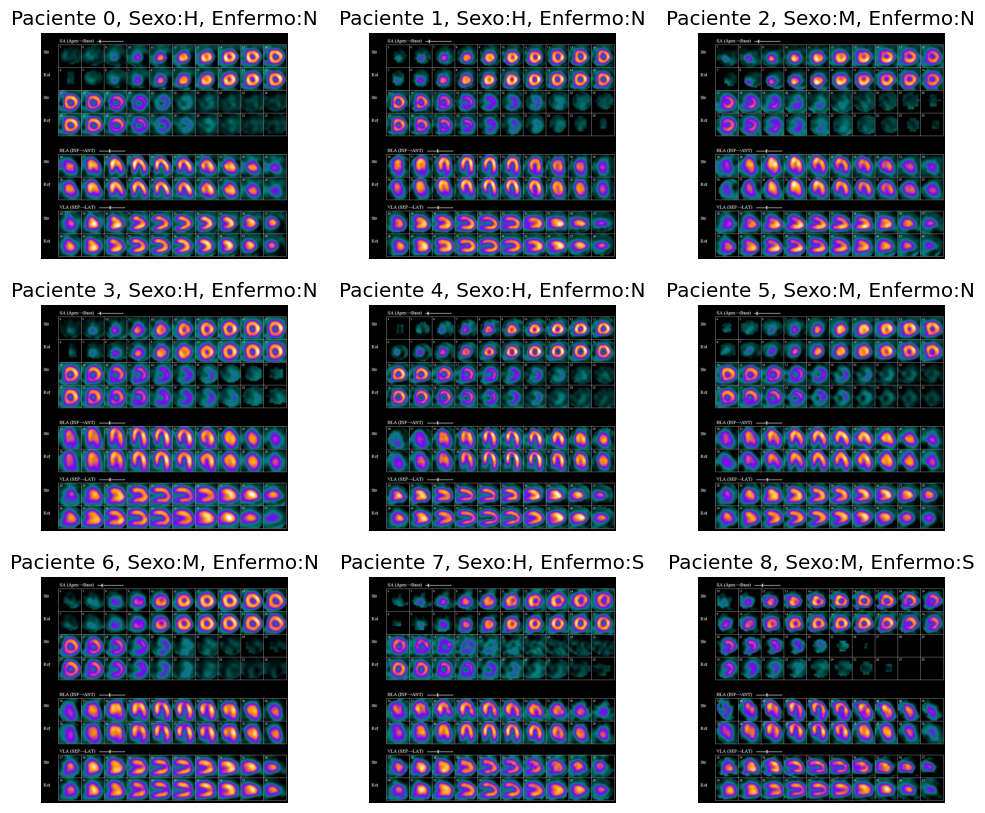

In [65]:
# Visualizo algunas de las imagenes cargadas
plt.figure(figsize=(12, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_Input1_val[i])           
    sexStr = ""    
    if (X_Input2_val[i][0] == 1):
        sexStr = 'H'
    else:
        sexStr = 'M'
    if (y_val[i] == 0):
        enf = "S"
    else:
        enf = "N"    
    plt.title("Paciente " + str(i) + ", Sexo:" + sexStr+ ", Enfermo:" + enf )
    plt.axis("off")



Defino el modelo sobre el cual validar 

In [80]:
# Definición del modelo 


# Defino la aumentación
data_augmentationB = tf.keras.Sequential([      
  tf.keras.layers.RandomFlip("horizontal"), 
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(factor=0.2),          
  tf.keras.layers.RandomBrightness(factor = 0.2)  
])

def cnn_modelB():
    initializer = keras.initializers.HeNormal()    
    # Primer modelo
    input1 = keras.Input(shape=(897, 976, 3), name="image")
        
    #Augmentation (no se utiliza el funcional)   
    augment = data_augmentationB(input1)    
        
    # Resize    
    resize = Resizing(height= 224,width= 224,interpolation="bilinear",
                      crop_to_aspect_ratio=False)(augment)      
        
    # Reescalado
    scaling2 = Rescaling(1./255,offset=0.0) (resize)

    # Convoluciones
    conv1 = Conv2D(16,(3, 3),activation="relu", padding="same",
                   kernel_initializer=initializer)(scaling2)        
    maxp1 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv1)
    drop1 = Dropout(.1, noise_shape=None, seed=None)(maxp1)
    
    batNorm1 = BatchNormalization() (drop1)

    conv2 = Conv2D(32,(3, 3),activation="relu", padding="same",
                   kernel_initializer=initializer)(batNorm1)    
    maxp2 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv2)
    drop2 = Dropout(.1, noise_shape=None, seed=None)(maxp2)
    
    batNorm2 = BatchNormalization() (drop2)

    conv3 = Conv2D(64,(3, 3),activation="relu", padding="same",
                   kernel_initializer=initializer)(batNorm2)    
    maxp3 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv3)
    drop3 = Dropout(.1, noise_shape=None, seed=None)(maxp3)
    
    
    batNorm3 = BatchNormalization() (drop3)

    conv4 = Conv2D(128,(3, 3),activation="relu", padding="same",                   
                   kernel_initializer=initializer)(batNorm3)    
    maxp4 = MaxPooling2D(pool_size=(2, 2), strides=2, name="lastConvLayer")(conv4)
    drop4 = Dropout(.1, noise_shape=None, seed=None)(maxp4)
    
    batNorm4 = BatchNormalization() (drop4)

    # Capa de flatten per convertir la imagen en un vector    
    flaten1 = Flatten(name="FlatenLayerOut1") (batNorm4)
    flaten2 = keras.Input(shape=(2,), name="sex")         
        
    # combinar salida con entrada sexo    
    combined = Concatenate()([flaten1, flaten2])    
        
    # Capa connectada a 128 neuronas y activación ReLU
    # Añado un regularizador pues es la capa que presenta mas parámetros
    dense1 = Dense(128, activation='relu',                                        
                    kernel_regularizer =tf.keras.regularizers.l1(0.001),
                    kernel_initializer=initializer) (combined)    
    drop5 = Dropout(.1, noise_shape=None, seed=None)(dense1)

    # Capa concetada a 128 neuronas y activación ReLU
    dense2 = Dense(128,activation='relu',
                   kernel_initializer=initializer)(drop5)    
    
    # Capa de clasificación
    dense3 = Dense(1, activation='sigmoid')(dense2)

    #model_func = Model(inputs=input1, outputs=dense3, name="RGB3-CNN")    
    model_func = Model(inputs=[input1, flaten2], outputs=dense3, name="RGB-CNN")    
    
    return model_func
 
cnnB_inst = cnn_modelB()        
cnnB_inst.summary()

Model: "RGB-CNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 897, 976,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, None,      │          0 │ image[0][0]       │
│ (Sequential)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_5          │ (None, 224, 224,  │          0 │ sequential_3[0][… │
│ (Resizing)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ resizing_5[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 224, 224,  │        448 │ rescaling_5[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 112, 112,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 112, 112,  │          0 │ max_pooling2d_15… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ dropout_25[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 112, 112,  │      4,640 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 56, 56,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 56, 56,    │          0 │ max_pooling2d_16… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        128 │ dropout_26[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 56, 56,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 28, 28,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 28, 28,    │          0 │ max_pooling2d_17… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ dropout_27[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 28, 28,    │     73,856 │ batch_normalizat

 Total params: 3,326,689 (12.69 MB)

 Trainable params: 3,326,209 (12.69 MB)

 Non-trainable params: 480 (1.88 KB)

### Optimización de hiperparámetros.

In [59]:
import keras_tuner as kt

class cnn_mixt_hyperModel(kt.HyperModel):
    def build(self, hp):
        # definir una función para entrenar el modelo
        modelMix_created = cnn_modelB()
        # Compilación 
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
        modelMix_created.compile(optimizer=Adam(learning_rate=hp_learning_rate),                    
                              loss="binary_crossentropy",                      
                              metrics=["accuracy"])        
        return modelMix_created

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [4, 8, 16, 32]),
            **kwargs,
        )

In [37]:
cnn_mixt_hyperModel(kt.HyperParameters())    
tuner = kt.Hyperband(cnn_mixt_hyperModel(),
                     objective='accuracy',
                     max_epochs=400,
                     factor=3,
                     overwrite=True,
                     directory='/kaggle/working/',
                     project_name='CNN_Mixt Best model')

# Control de mejora en la validación
callback =  EarlyStopping(monitor='val_loss',
                          patience=15, 
                          verbose=1, 
                          restore_best_weights=True)


# Se crea el array de parámetros de entrenamiento
X_Input_train = {'image': X_Input1_train, 'sex': X_Input2_train}
X_Input_val = {'image': X_Input1_val, 'sex': X_Input2_val}

tuner.search(x=X_Input_train, y= y_train, epochs=400, 
             validation_data=(X_Input_val, y_val),
             callbacks=[callback])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 12 Complete [00h 00m 10s]
accuracy: 0.6766666769981384

Best accuracy So Far: 0.7400000095367432
Total elapsed time: 00h 02m 02s


In [31]:
best_batch_size= best_hps.get('batch_size')
best_learning_rate = best_hps.get('learning_rate')

print('batch_size:', best_batch_size)
print('learning_rate:', best_learning_rate)
  

batch_size: 8
learning_rate: 0.0001


Dado que el batch_size y el learning rate dependen de las muestras seleccionadas al azar se escoge por defecto   
un batch_zise de 16 y un learning rate de 0.001 que dan buenos resultados.

Se entrena el modelo con este nuevo parámetro del sexo.

In [81]:
# Eliminar ficheros del directorio de trabajo    
# Compilación 
cnnB_inst.compile(optimizer=Adam(learning_rate=0.001),                         
                       loss="binary_crossentropy",
                       metrics=["accuracy"])

# Defino un nuevo tipo de control
callback2 = ReduceLROnPlateau(monitor='loss',patience=10)

# Control de mejora en la validación
callback =  EarlyStopping(monitor='val_loss',
                          patience=15, 
                          verbose=1, 
                          restore_best_weights=True)

# Se crea el array de parámetros de entrenamiento
X_Input_train = {'image': X_Input1_train, 'sex': X_Input2_train}
X_Input_val = {'image': X_Input1_val, 'sex': X_Input2_val}

# Entrenamiento
historyC = cnnB_inst.fit(x=X_Input_train, y=y_train,
                            validation_data=(X_Input_val, y_val),
                            epochs=400, 
                            shuffle=True, # Se fuerza a que los datos hagan shuffle 
                            batch_size=16,                             
                            callbacks=[callback,callback2])
                            #callbacks=[callback])

# Guardo el modelo   
cnnB_inst.save_weights("/kaggle/working/HibridModel.weights.h5")                      


Epoch 1/400


2024-05-24 21:04:50.714576: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/RGB-CNN_1/dropout_25_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.5644 - loss: 23.7181 - val_accuracy: 0.7188 - val_loss: 19.9181 - learning_rate: 0.0010
Epoch 2/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6910 - loss: 18.7702 - val_accuracy: 0.2188 - val_loss: 18.3233 - learning_rate: 0.0010
Epoch 3/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8248 - loss: 14.7376 - val_accuracy: 0.2188 - val_loss: 19.2005 - learning_rate: 0.0010
Epoch 4/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8159 - loss: 11.1271 - val_accuracy: 0.2188 - val_loss: 12.6927 - learning_rate: 0.0010
Epoch 5/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8230 - loss: 8.3747 - val_accuracy: 0.2188 - val_loss: 12.1611 - learning_rate: 0.0010
Epoch 6/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8868 - loss: 6.2327 - val_accuracy: 0.2188 - val_loss: 14.1005 - learning_rate: 0.0010
Epoch 7/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8590 - loss: 6.0600 - v

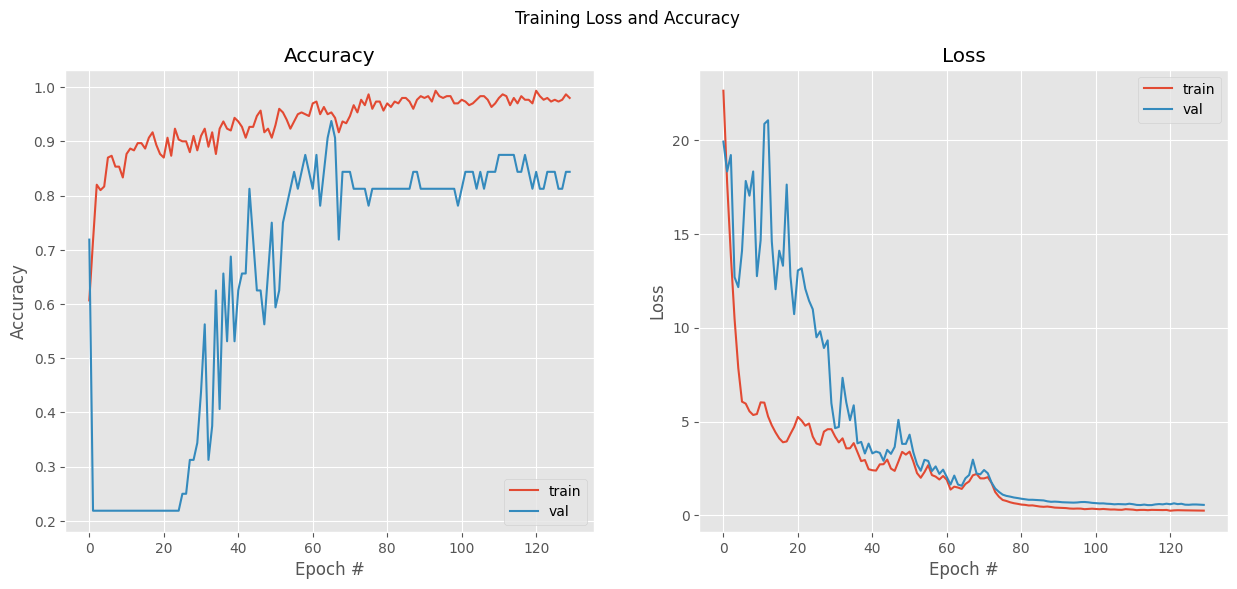

In [82]:
plot_training(130,historyC)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


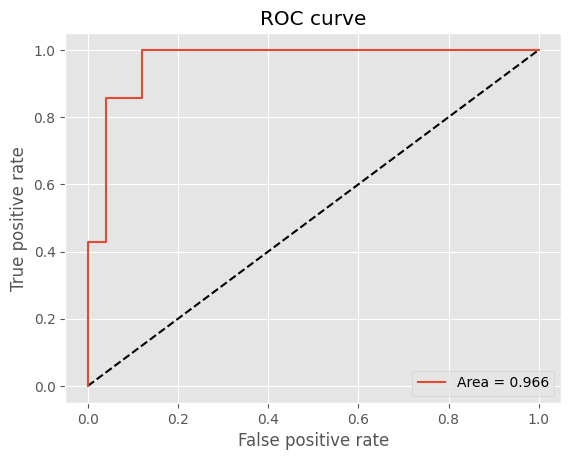

In [83]:
# Curva ROC
y_pred = cnnB_inst.predict([X_Input1_test,X_Input2_test])
plot_ROCInfo(y_test,y_pred)


Matriz de confusión:


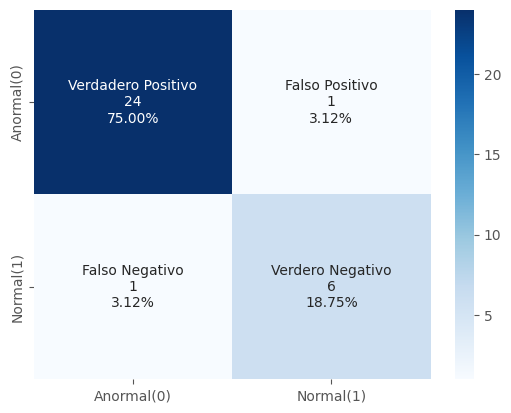

Exactitud: 0.9375
Precision:  0.9600
Sensibilidad:  0.9600
Especifidad:  0.8571
F1 Score:  0.9600


In [84]:
# Calculo la matriz de confusion
showMatrixMetrics(y_test,y_pred)



In [48]:
# Guardo pesos
cnnB_inst.save_weights('cnn_modelB_ref.weights.h5')


### Evaluación de la exactitud mediante la validación K-Fold estratificada

In [85]:
#Se cargan las librerias necesarias
from sklearn.model_selection import StratifiedKFold

scoreList_cnnB = []
hist_cnnB = []

X_Image_cnnB = np.concatenate((X_Input1_train,X_Input1_val), axis=0)
X_Sex_cnnB = np.concatenate((X_Input2_train,X_Input2_val), axis=0)
y_cnnB = np.concatenate((y_train, y_val), axis=0)

# Creo el modelo
cnnB_fold = cnn_modelB()

# Guardo pesos
#cnnB_fold.save_weights('cnn_modelB.weights.h5')

# KFold
kfold = StratifiedKFold(n_splits=10, shuffle=True)
for train_index, val_index in kfold.split(X_Image_cnnB,y_cnnB):        
    
    # Train fold
    X_train_fold1 = X_Image_cnnB[train_index]
    X_train_fold2 = X_Sex_cnnB[train_index]    
    
    # Validation fold
    X_val_fold1 = X_Image_cnnB[val_index]
    X_val_fold2 = X_Sex_cnnB[val_index]    
    
    # Se crea el array de parámetros de entrenamiento    
    X_Input_train = {'image': X_train_fold1, 'sex': X_train_fold2}
    X_Input_val = {'image': X_val_fold1, 'sex': X_val_fold2}
    X_Input_test = {'image': X_Input1_test, 'sex': X_Input2_test}


    y_train_fold = y_cnnB[train_index]
    y_val_fold = y_cnnB[val_index]
    
    # Defino Plateau
    callback2 = ReduceLROnPlateau(monitor='loss',patience=10)
    # Control de mejora en la validación
    callback =  EarlyStopping(monitor='val_loss',
                          patience=30, 
                          verbose=1, 
                          restore_best_weights=True)
    
    #cnnB_fold.load_weights('cnn_modelB.weights.h5')
          
    # Compilación 
    cnnB_fold.compile(optimizer=Adam(learning_rate=0.001),                         
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    
    history_now = cnnB_fold.fit(x= X_Input_train, y= y_train_fold,                               
                                   validation_data = (X_Input_val,y_val_fold),
                                   batch_size=16,
                                   verbose=0, 
                                   epochs=300, 
                                   callbacks=[callback,callback2]) 
    hist_cnnB.append(history_now)    
    
    
    y_test_pred = cnnB_fold.predict(X_Input_test)    
    accuracy,precision,recall,f1 = getScores(y_test,y_test_pred)    
    scoreList_cnnB.append((accuracy,precision,recall,f1))
    
    print ("-"*10)
    print ("Accuracy: %f"%(accuracy))    

2024-05-24 21:08:50.933403: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/RGB-CNN_1/dropout_30_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Restoring model weights from the end of the best epoch: 297.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
----------
Accuracy: 0.906250


2024-05-24 21:16:00.469983: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/RGB-CNN_1/dropout_30_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 209: early stopping
Restoring model weights from the end of the best epoch: 179.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
----------
Accuracy: 0.937500


2024-05-24 21:20:59.078073: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/RGB-CNN_1/dropout_30_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 154: early stopping
Restoring model weights from the end of the best epoch: 124.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
----------
Accuracy: 0.906250


2024-05-24 21:24:42.498721: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/RGB-CNN_1/dropout_30_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 208: early stopping
Restoring model weights from the end of the best epoch: 178.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
----------
Accuracy: 0.875000


2024-05-24 21:29:40.903895: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/RGB-CNN_1/dropout_30_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 173: early stopping
Restoring model weights from the end of the best epoch: 143.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
----------
Accuracy: 0.906250


2024-05-24 21:33:50.989654: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/RGB-CNN_1/dropout_30_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 221: early stopping
Restoring model weights from the end of the best epoch: 191.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
----------
Accuracy: 0.875000


2024-05-24 21:39:03.359399: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/RGB-CNN_1/dropout_30_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 197: early stopping
Restoring model weights from the end of the best epoch: 167.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
----------
Accuracy: 0.906250


2024-05-24 21:43:44.928016: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/RGB-CNN_1/dropout_30_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 231: early stopping
Restoring model weights from the end of the best epoch: 201.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
----------
Accuracy: 0.875000


2024-05-24 21:49:16.665557: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/RGB-CNN_1/dropout_30_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 222: early stopping
Restoring model weights from the end of the best epoch: 192.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
----------
Accuracy: 0.906250


2024-05-24 21:54:36.672936: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/RGB-CNN_1/dropout_30_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 277: early stopping
Restoring model weights from the end of the best epoch: 247.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
----------
Accuracy: 0.875000


In [118]:
# Muestro resultado

from statistics import mean, stdev
import math 
    
    
dt=np.dtype('float,float,float,float')
scoresTot =  np.array(scoreList_cnnB,dtype=dt)

scorteTotList = []
for x in scoresTot:
    scorteTotList.append(list(x))    
scoresTotArr = np.array(scorteTotList)
acc_List = scoresTotArr[:,0].tolist()

# Se añade un resultado óptimo obtenido en las pruebas
acc_List.append(0.968)
numRec = len(acc_List)

mean_Acc = mean(acc_List)
std_dev_Acc = stdev(acc_List)
# Error con un 95% de fiabilidad
error = 1.96 * std_dev_Acc/ math.sqrt(numRec)
 
print('Lista de exactitudes:',acc_List)
print('\n Máxima exactitud obtenida para este modelo:',
      max(acc_List)*100, '%')
print('\n Mínima exactitud obtenida:',
      min(acc_List)*100, '%')
print('\n Exactitud media:',
      round(mean(acc_List)*100,2), '%')
print('\n La desviación estandar es:', round(stdev(acc_List),3))
print('\n Margen de error con un nivel de confianza del 95%: ' + str(round(error*100,3)))


Lista de exactitudes: [0.90625, 0.9375, 0.90625, 0.875, 0.90625, 0.875, 0.90625, 0.875, 0.90625, 0.875, 0.968]

 Máxima exactitud obtenida para este modelo: 96.8 %

 Mínima exactitud obtenida: 87.5 %

 Exactitud media: 90.33 %

 La desviación estandar es: 0.029

 Margen de error con un nivel de confianza del 95%: 1.733


## 2.2  Modelo Hibrido RGB-CNN (+sexo)  con Cat-Boosting

Para hacer el modelo híbrido se entrena el modelo anterior para obtener los mejores resultados de entrenamiento; para ello  
se usan varios hiperparámetros.   
Se consideran variaciones en tamaño imagen, tasa de aprendizaje inicial(0.0001), valor de L2 normalización (0,0001).  
En una segunda fase, con el modelo entrenado, se añade un clasificador Cast-Boosting. Este clasificador usará las características  
extraidas del modelo entrenado, el learning rate a considerar estará en el rango 0.00001-0.1  

In [51]:
# Importo las librerias relacionadas
from catboost import CatBoostClassifier

In [54]:
# Recupero la capa de entrenamiento de CNN
# hasta la última capa convolucional

cnnB_inst.load_weights('cnn_modelB_ref.weights.h5')
feature_model = Model(inputs = cnnB_inst.layers[1].input,
                      outputs = cnnB_inst.get_layer('FlatenLayerOut1').output)                                

feature_model.summary()

# Obtengo las características de los datos para introducirlos en un clasificador CastBoosting
pred_train = feature_model.predict(X_Input1_train)
pred_val = feature_model.predict(X_Input1_val)
pred_test = feature_model.predict(X_Input1_test)

# Se concatena la característica del "sexo"
pred_train = np.concatenate((pred_train, X_Input2_train),axis=1)
pred_val = np.concatenate((pred_val, X_Input2_val),axis=1)
pred_test = np.concatenate((pred_test, X_Input2_test),axis=1)

# Configuro los parámetros del clasificador y entreno
# Pongo que la función de perdida sea "CrossEntropy"

cat_model = CatBoostClassifier(#iterations=1000, learning_rate=0.1,
                               loss_function='CrossEntropy',
                               eval_metric='Accuracy',
                               random_seed=42,
                               verbose=250)
# Entrenar el modelo
cat_model.fit(pred_train, y_train, eval_set=(pred_val, y_val),
                  early_stopping_rounds=50, verbose_eval=True)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 897, 976, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lastConvLayer (MaxPooling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FlatenLayerOut1 (Flatten)       │ (None, 25088)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,400 (384.38 KB)

 Trainable params: 97,920 (382.50 KB)

 Non-trainable params: 480 (1.88 KB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
0:	learn: 0.9566667	test: 0.7812500	best: 0.7812500 (0)	total: 2.83s	remaining: 47m 12s
1:	learn: 0.9700000	test: 0.7812500	best: 0.7812500 (0)	total: 4.69s	remaining: 39m 2s
2:	learn: 0.9766667	test: 0.7812500	best: 0.7812500 (0)	total: 7.01s	remaining: 38m 50s
3:	learn: 0.9800000	test: 0.8750000	best: 0.8750000 (3)	total: 8.86s	remaining: 36m 46s
4:	learn: 0.9866667	test: 0.8750000	best: 0.8750000 (3)	total: 10.7s	remaining: 35m 38s
5:	learn: 0.9866667	test: 0.8750000	best: 0.8750000 (3)	total: 12.6s	remaining: 34m 48s
6:	learn: 0.9866667	test: 0.8750000	best: 0.8750000 (3)	total: 14.5s	remaining: 34m 21s
7:	learn: 0.9833333	test: 0.8750000	best: 0.8750000 (3)	total: 16.5s	remaining: 34m 4s
8:	learn: 0.9900000	test: 0.8750000	best: 0.8750000 (3)	total: 18.4s	remaining: 33m 44s
9:	learn: 0.9966667	test: 0.8750000	best: 0.8750000 (3)	total: 20.4s	remaining: 33m 34s
10:	le

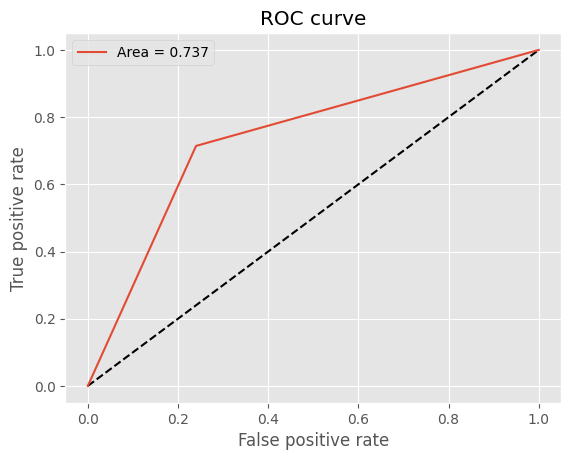

Matriz de confusión:


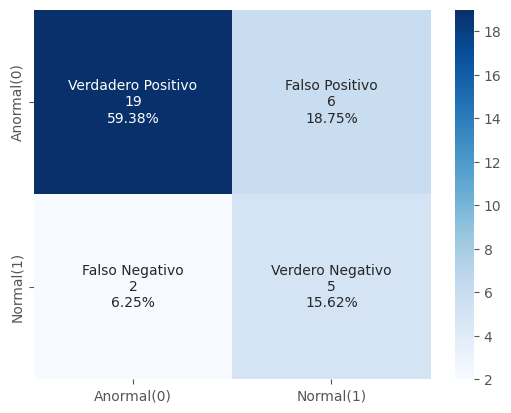

Exactitud: 0.7500
Precision:  0.7600
Sensibilidad:  0.9048
Especifidad:  0.4545
F1 Score:  0.8261


In [55]:
# Obtengo las métricas del modelo sobre los datos de test
y_test_pred = cat_model.predict(pred_test)

# Visualizo la curba ROC
plot_ROCInfo(y_test,y_test_pred)

# Las métricas de bondad del modelo son estas
showMatrixMetrics(y_test,y_test_pred)

## 2.3  Modelo CNN i-Net con multiples entradas

Para hacer el modelo cogeré el modelo inicial i-Net y añadiré un entrada adicional con la información del sexo.
Esta información se unirá a la información extraida de las capas convolucionales justo antes de la capa totalmente conectada.
Se consideran variaciones en tamaño imagen, tasa de aprendizaje inicial(0.0001), capas de normalización batch y 
una capa de regularización L1 con valor 0,0001.

In [25]:
# Definición del modelo 

# Defino la aumentación
data_augmentationINet = tf.keras.Sequential([      
  tf.keras.layers.RandomFlip("horizontal"), 
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(factor=0.2),          
  tf.keras.layers.RandomBrightness(factor = 0.2)  
])

def iNet_model():
    initializer = keras.initializers.HeNormal()    
    
    # Bloque extractor    
    input1 = keras.Input(shape=(897,976,3), name="image")    
    
    # Aumentación de datos
    augment = data_augmentationINet(input1)     
    
    # Resize    
    resize = Resizing(height= 224,width= 224,interpolation="bilinear",
                      crop_to_aspect_ratio=False)(augment)      
        
    # Reescalado
    scaling2 = Rescaling(1./255,offset=0.0) (resize)

    # Convoluciones
    conv1 = Conv2D(128,(2, 2),activation="relu", padding="same",
                   kernel_initializer=initializer)(scaling2)
    maxp1 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv1)
    
    conv2 = Conv2D(128,(2, 2),activation="relu", padding="same",
                   kernel_initializer=initializer)(maxp1)
    maxp2 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv2)
    drop2 = Dropout(.2, noise_shape=None, seed=None)(maxp2)
    
    batNorm1 = BatchNormalization() (drop2)

    conv3 = Conv2D(64,(2, 2),activation="relu", padding="same",
                   kernel_initializer=initializer)(batNorm1)
    maxp3 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv3)
    drop3 = Dropout(.25, noise_shape=None, seed=None)(maxp3)
    
    
    batNorm2 = BatchNormalization() (drop3)
    

    conv4 = Conv2D(32,(2, 2),activation="relu", padding="same",                   
                   kernel_initializer=initializer)(batNorm2)
    maxp4 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv4)
    drop4 = Dropout(.35, noise_shape=None, seed=None)(maxp4)
    
    batNorm3 = BatchNormalization() (drop4)
        
    conv5 = Conv2D(16,(2, 2),activation="relu", padding="same",                   
                   kernel_initializer=initializer)(batNorm3)
    maxp5 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv5)
    drop5 = Dropout(.45, noise_shape=None, seed=None)(maxp5)
    
    batNorm4 = BatchNormalization() (drop5)
    
    # Capa de flatten per convertir la imagen en un vector
    flaten1 = Flatten() (batNorm4)
    flaten2 = keras.Input(shape=(2,), name="sex")    
    
    # combinar salida con entrada sexo    
    combined = Concatenate()([flaten1, flaten2])    
        
    # Capa connectada a 128 neuronas y activación ReLU
    # Añado un regularizador pues es la capa que presenta mas parámetros
    
    dense1 = Dense(1024, activation='relu',                                        
                    kernel_regularizer =tf.keras.regularizers.l2(0.0001),
                    kernel_initializer=initializer) (combined)   
    
    drop5 = Dropout(.1, noise_shape=None, seed=None)(dense1)
    # Capa de clasificación
    dense3 = Dense(1, activation='sigmoid')(drop5)

    model_func = Model(inputs=[input1,flaten2], outputs=dense3, name="RGB-CNN")    
    
    return model_func
    
model_iNet = iNet_model();   
model_iNet.summary()


Model: "RGB-CNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 897, 976,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, None,      │          0 │ image[0][0]       │
│ (Sequential)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_4          │ (None, 224, 224,  │          0 │ sequential_2[0][… │
│ (Resizing)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ resizing_4[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 224, 224,  │      1,664 │ rescaling_4[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 112, 112,  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 112, 112,  │     65,664 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 56, 56,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 56, 56,    │          0 │ max_pooling2d_13… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ dropout_20[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 56, 56,    │     32,832 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 28, 28,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 28, 28,    │          0 │ max_pooling2d_14… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ dropout_21[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 28, 28,    │      8,224 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 14, 14,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 14, 14,    │          0 │ max_pooling2d_15

 Total params: 918,321 (3.50 MB)

 Trainable params: 917,841 (3.50 MB)

 Non-trainable params: 480 (1.88 KB)

In [26]:
# Entreno el modelo

# Eliminar ficheros del directorio de trabajo    
# Compilación 
model_iNet.compile(optimizer=Adam(learning_rate=0.001),                         
                   loss="binary_crossentropy",
                   metrics=["accuracy"])

# Defino un nuevo tipo de control
callback2 = ReduceLROnPlateau(monitor='loss',patience=5)

# Control de mejora en la validación
callback =  EarlyStopping(monitor='val_loss',
                          patience=10, 
                          verbose=1, 
                          restore_best_weights=True)

# Se crea el array de parámetros de entrenamiento
X_Input_train = {'image': X_Input1_train, 'sex': X_Input2_train}
X_Input_val = {'image': X_Input1_val, 'sex': X_Input2_val}

# Entrenamiento
historyD = model_iNet.fit(x=X_Input_train, y= y_train,
                            validation_data=(X_Input_val, y_val),
                            epochs=400, 
                            shuffle=True, # Se fuerza a que los datos hagan shuffle 
                            batch_size=1,                             
                            callbacks=[callback,callback2])

Epoch 1/400


2024-05-23 22:20:53.117520: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/RGB-CNN_1/dropout_20_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5802 - loss: 1.5061 - val_accuracy: 0.8125 - val_loss: 0.7244 - learning_rate: 0.0010
Epoch 2/400
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5950 - loss: 1.5430 - val_accuracy: 0.7812 - val_loss: 0.7684 - learning_rate: 0.0010
Epoch 3/400
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5646 - loss: 1.0624 - val_accuracy: 0.4375 - val_loss: 0.9273 - learning_rate: 0.0010
Epoch 4/400
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6511 - loss: 0.8622 - val_accuracy: 0.5000 - val_loss: 0.9703 - learning_rate: 0.0010
Epoch 5/400
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7053 - loss: 0.7975 - val_accuracy: 0.7812 - val_loss: 0.7539 - learning_rate: 0.0010
Epoch 6/400
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6851 - loss: 0.8578 - val_accuracy: 0.7812 - val_loss: 0.7256 - learning_rate: 0.0010
Epoch 7/400
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8154 - loss: 0.6408

Read /kaggle/input/spect2-mpi/SPECT_MPI2_Dataset/TestSet/Normal
<class 'list'>
Read /kaggle/input/spect2-mpi/SPECT_MPI2_Dataset/TestSet/Abnormal
<class 'list'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


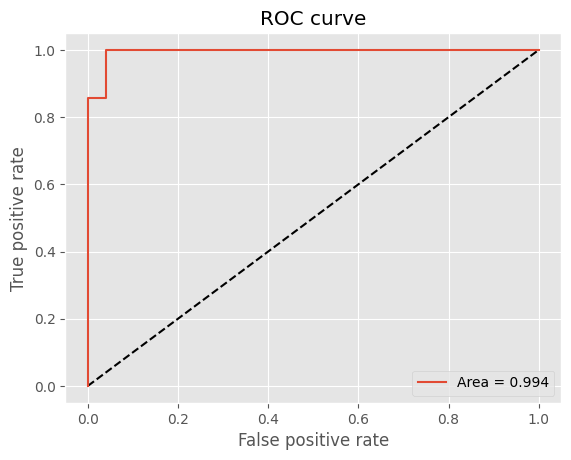

Matriz de confusión:


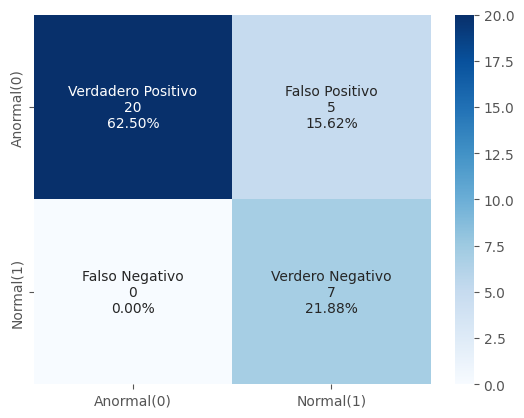

Exactitud: 0.8438
Precision:  0.8000
Sensibilidad:  1.0000
Especifidad:  0.5833
F1 Score:  0.8889


In [27]:
# Obtengo las métricas del modelo sobre los datos de test

ImgDir = "/kaggle/input/spect2-mpi/SPECT_MPI2_Dataset/TestSet"
X_Input1_test,X_Input2_test, y_test = getImageList(ImgInfFile,ImgDir)

y_test_pred = model_iNet.predict([X_Input1_test,X_Input2_test])

# Visualizo la curba ROC
plot_ROCInfo(y_test,y_test_pred)

# Las métricas de bondad del modelo son estas
showMatrixMetrics(y_test,y_test_pred)

## 2.4  VGG16 y DBSCAN para clasificación
En esta parte trataré de obtener las características principales de las imagenes que voy a tratar con el objetivo
de clasificarlas.   
Para ello utilizaré las características de las imagenes resultantes de un codificador junto a un  
bloque DBSCAN para agruparlas. El aprendizaje a tratar es un aprendizaje no supervisado.

In [16]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Cargar modelo VGG16 entrenado con la fuente "imagenet"
vgg16_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
## Marco el modelo como no entrenable
vgg16_model.trainable = False 
vgg16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
# Selecciono las imagenes de test y validación para extraer sus características

x_train, y_train = getImageInfo(train_data)
x_val, y_val = getImageInfo(val_data)
x_test, y_test = getImageInfo(val_data)
image_data = np.concatenate([x_train, x_val, x_test], axis=0 )
y_data = np.concatenate([y_train, y_val, y_test], axis=0 )

# Para reutilizar el modelo hay que preprocesar los datos tal como se
# hicieron durante el entrenamiento del modelo original con los datos originales
prep_image =  preprocess_input(image_data)

# Dimensiones
print("tipo" + str(type(prep_image)))
print ("Dimension image preprocesada : " + str(prep_image.shape))

tipo<class 'numpy.ndarray'>
Dimension image preprocesada : (364, 224, 224, 3)


In [18]:
#  Ahora se extraen las caracetrísticas.
img_features = vgg16_model.predict(prep_image)
print ("Dimensión características : " + str(img_features.shape))

# Se generan vectores de características de las imagenes
shapeRec = img_features.shape
numRec = shapeRec[0]
lenRec = shapeRec[1]*shapeRec[2]*shapeRec[3]
features_array = np.reshape(img_features, (numRec,lenRec))

print ("La dimensión de los vectores de características son " + str(features_array.shape))


 2/12 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step

I0000 00:00:1716574805.850596      95 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step 
Dimensión características : (364, 7, 7, 512)
La dimensión de los vectores de características son (364, 25088)


Aqui voy a realizar una reducción de vector de características, para ello utilizaré los componentes principales.


El número de elementos que contiene el 98% de la varianza es: 147


Text(0, 0.5, 'Varianza acumulativa explicada')

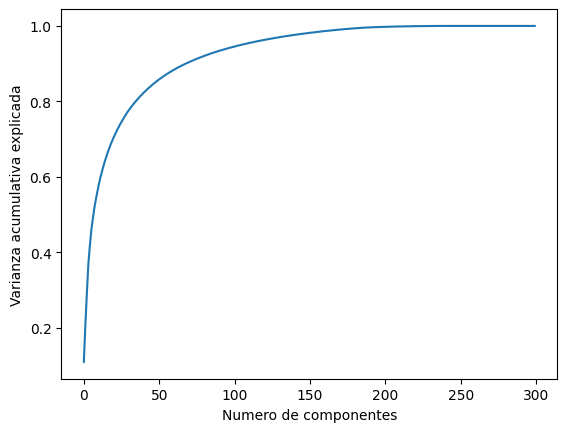

In [19]:
from sklearn import manifold
from sklearn.decomposition import PCA

# Hago un estudio previo de cual pueden ser los componentes principales mas importantes.
pca = PCA(n_components=300)
pca.fit(features_array)

# Determino el conjunto de variables que explican como mínimo el 98% se la varianza
cumsum = np.cumsum(pca.explained_variance_ratio_)
limitcumsum = cumsum[cumsum <=0.98]
pcNumber = limitcumsum.shape[0]

print("El número de elementos que contiene el 98% de la varianza es: " + str(pcNumber))

# Visualizo la gráfica
plt.plot(cumsum)
plt.xlabel('Numero de componentes')
plt.ylabel('Varianza acumulativa explicada')

De aquí determino que los componentes principales que explican el 98% de la varianza son los primeros 148 aproximadamente.

In [20]:

# Utilizo los primeros 147 componentes principales
pca = PCA(n_components=147)

# Los valores predichos
pred_pca = pca.fit_transform(features_array)
print("Shape despues de aplicar PCA {}".format(pred_pca.shape))

# Valores en formato de dataframe
feat_column_names = []
for i in range(pred_pca.shape[1]):
    feat_column_names.append('feature_{0}'.format(i+1))    
df_pred_pca = pd.DataFrame(pred_pca, columns = feat_column_names)
df_pred_pca.head()

Shape despues de aplicar PCA (364, 147)


feature_1   feature_2  feature_3   feature_4   feature_5   feature_6  \
0   32.414112 -149.358032  11.225933 -133.798615 -131.273453 -217.622513   
1  123.960045  119.678947 -69.373024  -47.832592  110.822716  -99.359146   
2  431.093262  125.331757  90.875610  256.127899  192.034286 -273.354187   
3   34.669155  -56.452732 -75.836006  167.230698   72.665749 -162.313293   
4  -20.292261 -323.987823  82.133591 -336.116211  133.194138  -36.557941   

    feature_7   feature_8   feature_9  feature_10  ...  feature_138  \
0  202.121658  278.826080   32.300827   44.414810  ...     0.654964   
1  -63.212524   59.357090   71.454498 -104.308708  ...   -16.232441   
2  147.526627 -252.181931  130.982605  -85.125694  ...     1.960338   
3   -9.347284  131.750793  -25.467709  -99.309669  ...     6.753253   
4 -109.492058   -4.701711  -63.722366  -27.906733  ...     6.915385   

   feature_139  feature_140  feature_141  feature_142  feature_143  \
0     9.928330     4.088281    -5.291278    -1.480303    -1.662231   
1    -4.420752    -7.339108     4.222258    -2.986334    -7.590772   
2   -15.630454    22.742346   -27.533531    -5.300505    -5.402075   
3     1.732061   -16.429491    -7.420970    -6.086496    -4.513154   
4     3.273985    -0.677820    -3.032159    -2.113562    -3.494941   

   feature_144  feature_145  feature_146  feature_147  
0    -4.169933    -9.213189    -5.668921     1.176100  
1    -5.619864    -3.786083    -9.476336   -10.585312  
2     4.218776    12.044934    -9.270996     0.779997  
3    -1.414744     5.720420    -2.718251    -2.583725  
4     2.706918     5.460948    10.673615    -5.926227  

[5 rows x 147 columns]

Ahora aplico el método de K-Means para obtener el número de clusters.
Lo primero que tengo que hacer es determinar el número óptimo de clusters, para ello aplico la técnica del codo.
En esta técnica se calcula la suma dels errors quadràtics (SSE) para cada número de clusters a detectar.
Este procediment se realiza per a cada posible valor, obteniendo un función monótona decreciente, donde el eje "x" representa los valores de K y el "y" el SEE. 
Intuitivamente se puede observar un descenso significativo del error que indicará un valor idoneo de K.


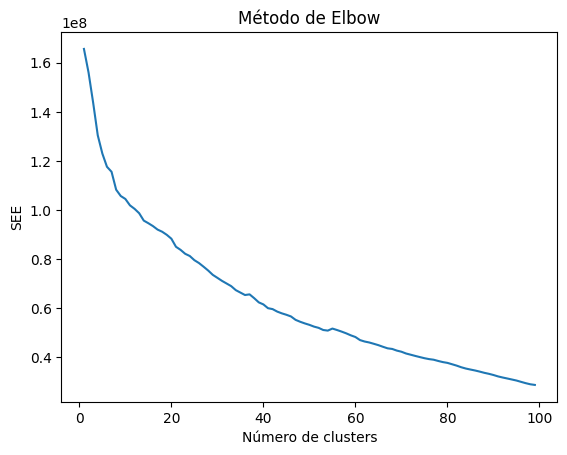

In [21]:
see = []
grups = list(range(1,100))
for i in grups:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init='auto', random_state = 42)
    kmeans.fit(pred_pca)
    
    # Sum of squared distances of samples to their closest cluster center, 
    cluster_centers = [pred_pca[kmeans.labels_ == j].mean(axis=0) for j in range(i)]    
        
    cluster_sse = [0] * 100
    for point, label in zip(pred_pca, kmeans.labels_):        
        cluster_sse[label] += np.square(point - cluster_centers[label]).sum()             
    see.append(sum(cluster_sse))

# Grafica de la suma de las distancias
plt.plot(grups, see)
plt.title('Método de Elbow')
plt.xlabel('Número de clusters')
plt.ylabel('SEE')

plt.show()    


Aquí no se puede ver exactamente donde empieza el codo de la gráfica, se puede intuir un K= 7 con poca precisión.

In [22]:
import sklearn.metrics as metrics
# Ahora lo miro aplicando el método de silhouette
SK = range(3,240,10)
sil_score = []
for i in SK:
    labels= KMeans(n_clusters=i,init="k-means++", n_init='auto',random_state=200).fit(pred_pca).labels_
    score = metrics.silhouette_score(pred_pca,labels,metric="euclidean",random_state=32)
    sil_score.append(score)
    print ("Silhouette score para k(clusters) = "+str(i)+" es "
           +str(metrics.silhouette_score(pred_pca,labels,metric="euclidean",random_state=32)))

Silhouette score para k(clusters) = 3 es 0.11250356
Silhouette score para k(clusters) = 13 es 0.19917415
Silhouette score para k(clusters) = 23 es 0.24802327
Silhouette score para k(clusters) = 33 es 0.2901896
Silhouette score para k(clusters) = 43 es 0.33373278
Silhouette score para k(clusters) = 53 es 0.36016476
Silhouette score para k(clusters) = 63 es 0.41963792
Silhouette score para k(clusters) = 73 es 0.45078564
Silhouette score para k(clusters) = 83 es 0.4718574
Silhouette score para k(clusters) = 93 es 0.48233402
Silhouette score para k(clusters) = 103 es 0.5060854
Silhouette score para k(clusters) = 113 es 0.52190775
Silhouette score para k(clusters) = 123 es 0.5228833
Silhouette score para k(clusters) = 133 es 0.5297586
Silhouette score para k(clusters) = 143 es 0.53911203
Silhouette score para k(clusters) = 153 es 0.54512167
Silhouette score para k(clusters) = 163 es 0.5482717
Silhouette score para k(clusters) = 173 es 0.55065006
Silhouette score para k(clusters) = 183 es 0.

El valor máximo de la silueta es k = 210 con valor 0.56870633


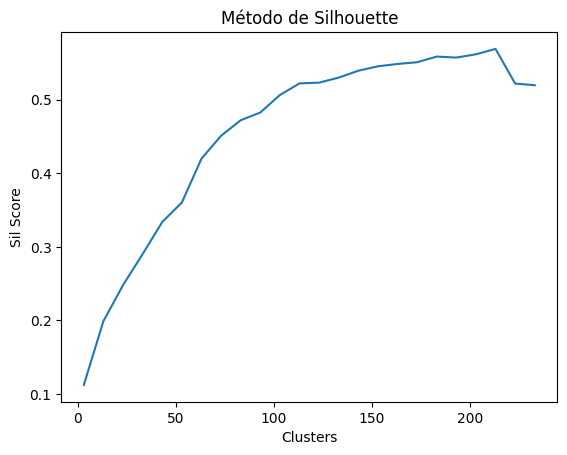

In [23]:
# El punto con valor máximo en la gráfica
valMax =  max(sil_score)
print('El valor máximo de la silueta es k = ' +  str(sil_score.index(valMax) * 10) + " con valor " + str(valMax))

# Grafica metodo de las siluetas
plt.plot(SK, sil_score)
plt.title('Método de Silhouette')
plt.xlabel('Clusters')
plt.ylabel('Sil Score')
plt.show()    

El pico de la gráfica tiene una valor de K muy elevado, el resultado no es bueno.
Se prueba un algoritmo DBSCAN basado en desnidad para ver si es problema del método K-Means.

In [24]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Determino los vectores máximo y mínimo de las características para calcular la distancia máxima de dos puntos
pred_pca_max = np.amax(pred_pca, axis = 0)
pred_pca_min = np.amin(pred_pca, axis = 0)
dist = np.linalg.norm(pred_pca_max - pred_pca_min)
print("La distancia máxima entre dos puntos es :" + str(dist))

# Se crea DBSCAN jugando con los parámetros epsilon
# eps = the maximum distance between two samples for one to be considered as in the neighborhood of the other
num_clusters = []
eps_values =[]
for i in np.arange(0.1,8096/10,20):
    dbscan = DBSCAN(eps=i, min_samples=5)
    dbscan.fit(pred_pca)    
    ngrups = len(np.unique(dbscan.labels_, return_counts=False))
    noClasif= len(dbscan.labels_[dbscan.labels_<0])     
    # Visualizo resultado
    print("Epsilon=" + str(i) + "; No clasificados=" + str(noClasif) + "; Número de grupos=" +str(ngrups))    
    # Guardo la información del numero de clusters y resto 1 si no clasificados
    num_clusters.append((ngrups,noClasif) )        
    eps_values.append(i)

La distancia máxima entre dos puntos es :4109.16
Epsilon=0.1; No clasificados=289; Número de grupos=7
Epsilon=20.1; No clasificados=289; Número de grupos=7
Epsilon=40.1; No clasificados=289; Número de grupos=7
Epsilon=60.1; No clasificados=289; Número de grupos=7
Epsilon=80.1; No clasificados=289; Número de grupos=7
Epsilon=100.1; No clasificados=289; Número de grupos=7
Epsilon=120.1; No clasificados=280; Número de grupos=8
Epsilon=140.1; No clasificados=266; Número de grupos=10
Epsilon=160.1; No clasificados=264; Número de grupos=10
Epsilon=180.1; No clasificados=264; Número de grupos=10
Epsilon=200.1; No clasificados=264; Número de grupos=10
Epsilon=220.1; No clasificados=264; Número de grupos=10
Epsilon=240.1; No clasificados=264; Número de grupos=10
Epsilon=260.1; No clasificados=264; Número de grupos=10
Epsilon=280.1; No clasificados=264; Número de grupos=10
Epsilon=300.1; No clasificados=264; Número de grupos=10
Epsilon=320.1; No clasificados=258; Número de grupos=11
Epsilon=340.

El resultado tampoco es bueno, al variar la epsilon el número de imagenes no clasificadas se reduce muy léntamente.  
Se muestra de manera gráfica el resultado para una epsilon de 700.1; este valor se escoge como aleatoriamente, ya que intuitivamente podría ser un   
resultado válido.

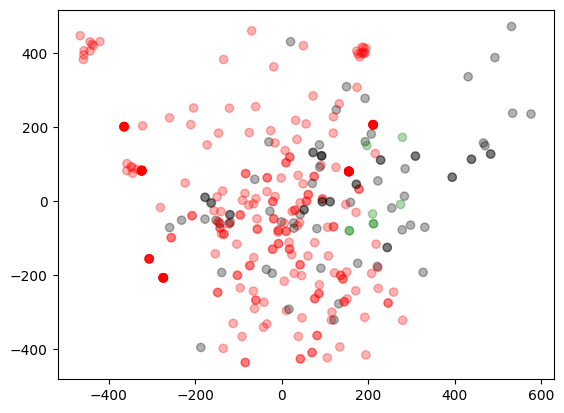

In [25]:
# Visualizo en una gráfica 2D os dos primeros elementos de los vectores.
dbscan = DBSCAN(eps=700, min_samples=5)
dbscan.fit(pred_pca)
# Defino el color de los 7 grupos
colors4=['red','green','blue','yellow','orange','purple','olive']
asigColor4=[]
for row in dbscan.labels_:
    if (row < 0) : 
        asigColor4.append('black')   
    else :
        asigColor4.append(colors4[row])        
        
fig = plt.figure()
ax5= fig.add_subplot(111)
ax5.scatter(pred_pca[:,1:2], pred_pca[:,2:3], c=asigColor4, alpha=.3)

No se aprecia ninguna forma de agrupación en la gráfica.  
Mediante un histograma represento como se asignan los grupos capturados con la información  
que tengo sobre si un paciente tiene o no tiene la enfermedad.

<Axes: xlabel='Grupo'>

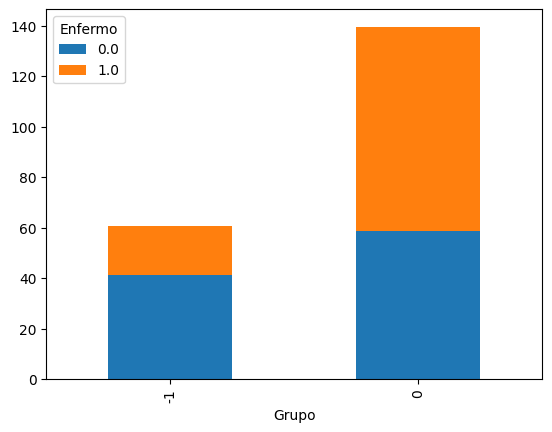

In [26]:
# Histograma apilado de etiquetas versus clasificación de enfermo o no enfermo
dbscan = DBSCAN(eps=700, min_samples=10)
dbscan.fit(pred_pca)
#
numRecY = y_data.shape[0]
y_data2 = y_data.reshape(numRecY,)

# El model amb els valors dels components es mostra en un dataFrame
df_map = pd.DataFrame({ "Grupo": dbscan.labels_, "Enfermo": y_data2} )

# Gráficos apilados
plotBar = pd.crosstab(index=df_map['Grupo'],columns=df_map['Enfermo']).apply(lambda r: r/r.sum() *100,axis=0)
plotBar.plot(kind='bar', stacked=True)

Con este resultado solo se puede ver un grupo, el otro grupo corresponde a no clasificados.

## 2.5  NasNet-Large y DBSCAN para clasificación no supervisada
En este apartado utilizaré un clasificador diferente llamad Nasnet, que es el mejor clasificador existente hasta el momento.  
El procedimiento a seguir será análogo al del apartado 2.4.
El claisifcador NASNET tiene como entrada un vector de imagen de dimensión (224, 224, 3).

In [27]:
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Inicialización del modelo
nasnet_model = NASNetLarge(input_shape=(224,224,3), include_top = False, weights = 'imagenet')
## Marco el modelo como no entrenable
nasnet_model.trainable = False 
#nasnet_model.summary()

343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [28]:
from tensorflow.keras.applications.nasnet import preprocess_input

# Selecciono las imagenes de test/validación para extraer sus características

x_train, y_train = getImageInfo(train_data)
x_val, y_val = getImageInfo(val_data)
x_test, y_test = getImageInfo(test_data)

image_data = np.concatenate([x_train, x_val,x_test], axis=0 )
y_data = np.concatenate([y_train, y_val,y_test], axis=0 )

# Para reutilizar el modelo hay que preprocesar los datos tal como se
# hicieron durante el entrenamiento del modelo original con los datos originales
prep_image =  preprocess_input(image_data)

# Dimensiones
print("tipo" + str(type(prep_image)))
print ("Dimension image preprocesada : " + str(prep_image.shape))

tipo<class 'numpy.ndarray'>
Dimension image preprocesada : (364, 224, 224, 3)


In [29]:
#  Ahora se extraen las caracetrísticas.
img_features = nasnet_model.predict(prep_image)
print ("Dimensión características : " + str(img_features.shape))

# Se generan vectores de características de las imagenes
shapeRec = img_features.shape
numRec = shapeRec[0]
lenRec = shapeRec[1]*shapeRec[2]*shapeRec[3]
features_array = np.reshape(img_features, (numRec,lenRec))

print ("La dimensión de los vectores de características son " + str(features_array.shape))


12/12 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step 
Dimensión características : (364, 7, 7, 4032)
La dimensión de los vectores de características son (364, 197568)


El número de elementos que contiene el 98% de la varianza es: 163


Text(0, 0.5, 'Varianza acumulativa explicada')

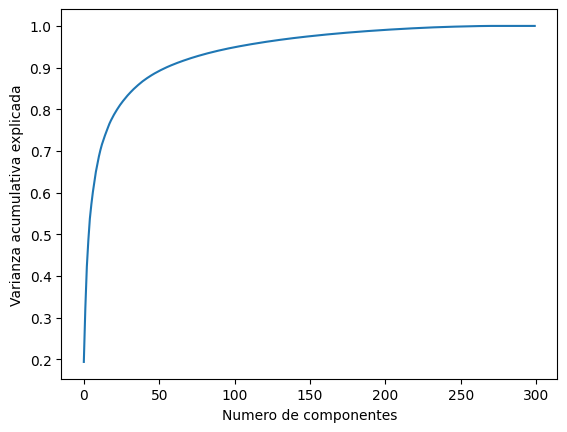

In [30]:
# Búsqueda de los componentes principales

from sklearn import manifold
from sklearn.decomposition import PCA

# Hago un estudio previo de cual pueden ser los componentes principales mas importantes.
pca = PCA(n_components=300)
pca.fit(features_array)

# Determino el conjunto de variables que explican como mínimo el 98% se la varianza
cumsum = np.cumsum(pca.explained_variance_ratio_)
limitcumsum = cumsum[cumsum <=0.98]
pcNumber = limitcumsum.shape[0]

print("El número de elementos que contiene el 98% de la varianza es: " + str(pcNumber))

# Visualizo la gráfica
plt.plot(cumsum)
plt.xlabel('Numero de componentes')
plt.ylabel('Varianza acumulativa explicada')

In [31]:
# Utilizo los primeros 163 componentes principales
pca = PCA(n_components=163)

# Los valores predichos
pred_pca = pca.fit_transform(features_array)
print("Shape despues de aplicar PCA {}".format(pred_pca.shape))

# Valores en formato de dataframe
feat_column_names = []
for i in range(pred_pca.shape[1]):
    feat_column_names.append('feature_{0}'.format(i+1))    
df_pred_pca = pd.DataFrame(pred_pca, columns = feat_column_names)
df_pred_pca.head()

Shape despues de aplicar PCA (364, 163)


feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  -66.845474   6.764442  56.021324  47.435261  31.594860  -2.381600   
1   -8.344020  20.049448  -2.880280  27.658422 -18.799366 -26.201427   
2  -76.599350 -16.895172  28.786236   6.998885 -10.130031   1.068914   
3  136.405441 -62.459637  43.307045  19.997501  23.137291  -8.644969   
4  -20.603430 -49.844501 -37.714336  19.444223  27.342587  39.970867   

   feature_7  feature_8  feature_9  feature_10  ...  feature_154  feature_155  \
0   5.194412 -24.379675  11.727269   12.270811  ...     1.678427     2.704783   
1 -18.487841  10.694148  11.715573    2.147237  ...    -3.236681    -0.561339   
2 -32.121693  -6.428589 -21.058620  -20.453501  ...     2.788115    -3.038553   
3   3.454148  -1.154855  -7.292396   -4.402358  ...    -0.352504    -0.087492   
4  56.035469 -53.911095 -11.307008   25.453339  ...     0.223230    -0.368501   

   feature_156  feature_157  feature_158  feature_159  feature_160  \
0    -4.052269    -1.198419     6.151464     0.203863    -3.485097   
1     3.225355    -9.597142    -0.102828     2.190341    -2.286108   
2     4.646086     5.682844     0.311424    -2.210171     5.012815   
3    -0.071991    -0.031856    -0.143580     0.037102     0.012896   
4    -0.434853     0.462737    -0.993522     0.945487     0.025014   

   feature_161  feature_162  feature_163  
0    -3.361773     1.201221    -1.351336  
1    -6.072811    -1.644032    -2.451633  
2    -1.279126    -1.582293    -3.121064  
3     0.031477    -0.087051    -0.016821  
4    -0.278883    -0.319418    -0.204233  

[5 rows x 163 columns]

La varianza explicada de cada componente está muy repartida, tal como se puede si la visualizo; no obstante  
los 3 primeros componentes tienen un peso considerable, lo cual es ideal para mostrarlo de manera gráfica.

Gráfico donde se muestra los dos primeros componentes principales.

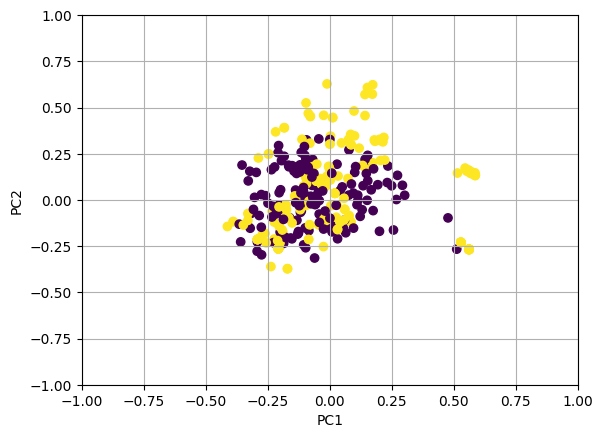

In [32]:
def plotPCA(score):
    xs = score[:,0]
    ys = score[:,1]    
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y_data)    
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

# Representación de los componentes PC1 y PC2 reescalados
plotPCA(pred_pca[:,0:2])
plt.show()

Aquí se puede comprobar que el resultado es muy parecido, con lo que no es problema de la red CCN.  
Voy a probar con otro algoritmo de agrupamiento mas preciso.


In [35]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Determino los vectores máximo y mínimo de las características para calcular la distancia máxima de dos puntos
pred_pca_max = np.amax(pred_pca, axis = 0)
pred_pca_min = np.amin(pred_pca, axis = 0)
dist = np.linalg.norm(pred_pca_max - pred_pca_min)
print("La distancia máxima entre dos puntos es :" + str(dist))

# Se crea DBSCAN jugando con los parámetros epsilon
# eps = the maximum distance between two samples for one to be considered as in the neighborhood of the other
num_clusters = []
eps_values =[]
for i in np.arange(0.1,200,15):
    dbscan = DBSCAN(eps=i, min_samples=5)
    dbscan.fit(pred_pca)    
    ngrups = len(np.unique(dbscan.labels_, return_counts=False))
    noClasif= len(dbscan.labels_[dbscan.labels_<0])     
    # Visualizo resultado
    print("Epsilon=" + str(i) + "; No clasificados=" + str(noClasif) + "; Número de grupos=" +str(ngrups))    
    # Guardo la información del numero de clusters y resto 1 si no clasificados
    num_clusters.append((ngrups,noClasif) )        
    eps_values.append(i)

La distancia máxima entre dos puntos es :740.1157
Epsilon=0.1; No clasificados=289; Número de grupos=7
Epsilon=15.1; No clasificados=289; Número de grupos=7
Epsilon=30.1; No clasificados=283; Número de grupos=8
Epsilon=45.1; No clasificados=264; Número de grupos=9
Epsilon=60.1; No clasificados=258; Número de grupos=8
Epsilon=75.1; No clasificados=258; Número de grupos=8
Epsilon=90.1; No clasificados=252; Número de grupos=9
Epsilon=105.1; No clasificados=167; Número de grupos=8
Epsilon=120.1; No clasificados=89; Número de grupos=8
Epsilon=135.1; No clasificados=35; Número de grupos=6
Epsilon=150.1; No clasificados=5; Número de grupos=2
Epsilon=165.1; No clasificados=1; Número de grupos=2
Epsilon=180.1; No clasificados=0; Número de grupos=1
Epsilon=195.1; No clasificados=0; Número de grupos=1


Según los datos obtenidos, un resultado interesane puede ser el relacionado con un grupo de 5 tipos, donde hay 26 que se clasifican mal.
El resultado de dos grupos es lo que tenemos actualmente, en este se clasifican bien 2 elementos.

Mediante un histograma se va a mostrar la correlación de los grupos con los pacientes sanos y enfermos.


Tabla de frecuencias por grupo de pacientes
Enfermo   Si   No
Grupo            
-1         8   45
 0       142  114
 1         0   30
 2         0   15
 3         0   10
Tabla de frecuencias normalizada por grupo de pacientes
Enfermo         Si         No
Grupo                        
-1        5.333333  21.028037
 0       94.666667  53.271028
 1        0.000000  14.018692
 2        0.000000   7.009346
 3        0.000000   4.672897


Text(0, 0.5, 'Porcentaje de enfermos y no enfermos')

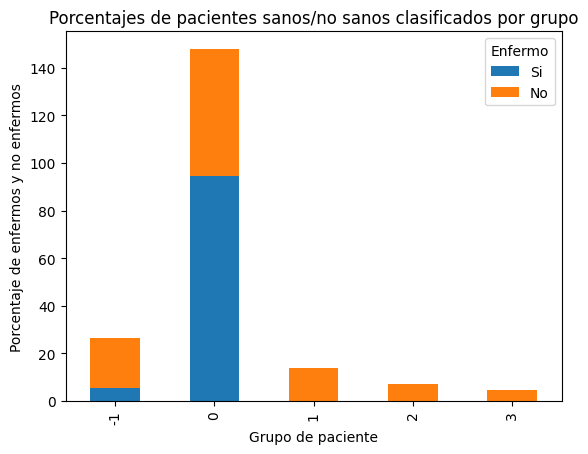

In [36]:
# Histograma apilado de etiquetas versus clasificación de enfermo o no enfermo
dbscan = DBSCAN(eps=135.1, min_samples=10)
dbscan.fit(pred_pca)
#
numRecY = y_data.shape[0]
y_data2 = y_data.reshape(numRecY,)

# Se muestra en un dataframe un histograma con los grupos existentes y el porcentaje que corresponden a pacientes enfermos
df_map2 = pd.DataFrame({ "Grupo": dbscan.labels_, "Enfermo": y_data2} )
# Gráficos apilados
df_crosstab = pd.crosstab(index=df_map2['Grupo'], columns=df_map2['Enfermo'])
df_crosstab.rename(columns = {0: "Si", 1: "No"},inplace=True)
print("Tabla de frecuencias por grupo de pacientes")
print(df_crosstab)

# Gráficos apilados
# Calculo el porcentaje a lo largo de las filas
df_crosstab2 = df_crosstab.apply(lambda r: r/r.sum() * 100,axis=0)
# Porcentaje de grupos
print("Tabla de frecuencias normalizada por grupo de pacientes")
print(df_crosstab2)
# Visualizo resultados
ax = df_crosstab2.plot(kind='bar', stacked=True)
plt.title("Porcentajes de pacientes sanos/no sanos clasificados por grupo")
ax.set_xlabel("Grupo de paciente")
ax.set_ylabel("Porcentaje de enfermos y no enfermos")


En esta gráfica se tiene que el 98% de los pacientes enfermos se clasifican en el grupo 0, el 0.67 % se situan en el grupo 1 y el resto no se pueden clasificar en ningún grupo.  
Curiosamente la mayor parte de los sanos, el 55 % puede pertenecer también al grupo 0.   
Si se supone que que todos los pacientes del grupo 0 deben ser enfermos y que los pacientes clasificados como sanos del grupo 1 son  
incorrectos la exactitud del modelo para detectar pacientes enfermos es del 67 % y la precisión del 98%.     

In [37]:
# Calculo de los parámetros de la matriz de confusión adaptada 

PatN_TP = df_crosstab["No"][-1] + df_crosstab["No"][1] + df_crosstab["No"][2] + df_crosstab["No"][3]
PatN_FP = df_crosstab["No"][0]

PatAbN_TP = df_crosstab["Si"][0] 
PatAbN_FP = df_crosstab["Si"][-1] +  df_crosstab["Si"][1] + df_crosstab["Si"][2] + df_crosstab["Si"][3]

accuracy =  ((PatAbN_TP + PatN_TP)  / (PatN_TP + PatN_FP + PatAbN_TP + PatAbN_FP))* 100
precision =  PatAbN_TP / (PatAbN_TP + PatAbN_FP) * 100

print ("Exactitud: " + str(round(accuracy,2)) + "%")
print ("Precision: " + str(round(precision,2)) + "%")

Exactitud: 66.48%
Precision: 94.67%


## Aplicando UMAP

Para mejorar los resultados se va a reducir las dimensiones aplicando otro algoritmo mas eficiente que respeta mas  
la geometría euclidiana de las muestras. En este caso voy a aplicar el algoritmo UMAP a una dimensión de 163.

In [38]:
# Aplico el algoritmo UMAP para reducir las dimensiones
# Este algoritmo tiene por defecto una reducción dimensional a 2D.
# Hago un barrido para ver cual es el mejor número de clusters
import umap
 
umap_reducer = umap.UMAP(n_components = 163 ,n_neighbors=15, min_dist=0.1, metric='euclidean' )    
X_umap_reduced = umap_reducer.fit_transform(features_array)    

Ahora visualizo el resultado

(364, 163)
(364,)


<Figure size 2500x2500 with 0 Axes>

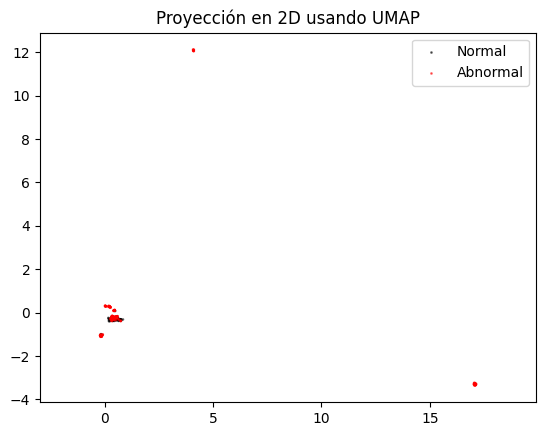

In [39]:
# Ahora hago la visualización con diferentes colores

colors = ['black','red']

print(X_umap_reduced.shape)
print(y_data2.shape)

plt.figure(figsize=(25, 25))
fig, ax = plt.subplots()

def readColors(y_colors):
    result= []
    for y_color in y_colors:
        result.append(colors[int(y_color)])        
    return result

#
mask = (y_data2 == 0)    
colList = readColors(y_data2[mask])    
plt.scatter(X_umap_reduced[mask,0],X_umap_reduced[mask,1], c=colList, label='Normal',alpha=0.5, s=1)    
#
mask = (y_data2 == 1)    
colList = readColors(y_data2[mask])    
plt.scatter(X_umap_reduced[mask,0],X_umap_reduced[mask,1], c=colList, label='Abnormal',alpha=0.5, s=1)    

ax.legend()
plt.title('Proyección en 2D usando UMAP');
plt.gca().set_aspect('equal', 'datalim')
plt.show()

Ahora aplico el algoritmo DBSCAN con el nuevo espacio vectorial.

In [40]:
# Se crea DBSCAN jugando con los parámetros epsilon
# eps = the maximum distance between two samples for one to be considered as in the neighborhood of the other
num_clusters = []
eps_values =[]
for i in np.arange(0.8,1,0.02):
    dbscan_u = DBSCAN(eps=i, min_samples=5)
    dbscan_u.fit(X_umap_reduced)    
    ngrups_u = len(np.unique(dbscan_u.labels_, return_counts=False))
    noClasif_u= len(dbscan_u.labels_[dbscan_u.labels_<0])     
    # Visualizo resultado
    print("Epsilon=" + str(i) + "; No clasificados=" + str(noClasif_u) + "; Número de grupos=" +str(ngrups_u))    
    # Guardo la información del numero de clusters y resto 1 si no clasificados
    num_clusters.append((ngrups_u,noClasif_u) )        
    eps_values.append(i)

Epsilon=0.8; No clasificados=0; Número de grupos=7
Epsilon=0.8200000000000001; No clasificados=0; Número de grupos=7
Epsilon=0.8400000000000001; No clasificados=0; Número de grupos=7
Epsilon=0.8600000000000001; No clasificados=0; Número de grupos=7
Epsilon=0.8800000000000001; No clasificados=0; Número de grupos=7
Epsilon=0.9000000000000001; No clasificados=0; Número de grupos=6
Epsilon=0.9200000000000002; No clasificados=0; Número de grupos=6
Epsilon=0.9400000000000002; No clasificados=0; Número de grupos=6
Epsilon=0.9600000000000002; No clasificados=0; Número de grupos=6
Epsilon=0.9800000000000002; No clasificados=0; Número de grupos=6


Muestro el resultado aplicando un DBSCAN estableciendo epsilon a 0.82

In [41]:
# Histograma apilado de etiquetas versus clasificación de enfermo o no enfermo
dbscan_umap = DBSCAN(eps=0.90, min_samples=5)
dbscan_umap.fit(X_umap_reduced)

DBSCAN(eps=0.9)

Tabla de frecuencias por grupo de pacientes
Enfermo   Si  No
Grupo           
0        142  81
1          2  24
2          1  30
3          5  37
4          0  32
5          0  10
Tabla de frecuencias normalizada por grupo de pacientes
Enfermo         Si         No
Grupo                        
0        94.666667  37.850467
1         1.333333  11.214953
2         0.666667  14.018692
3         3.333333  17.289720
4         0.000000  14.953271
5         0.000000   4.672897


Text(0, 0.5, 'Porcentaje de enfermos y no enfermos')

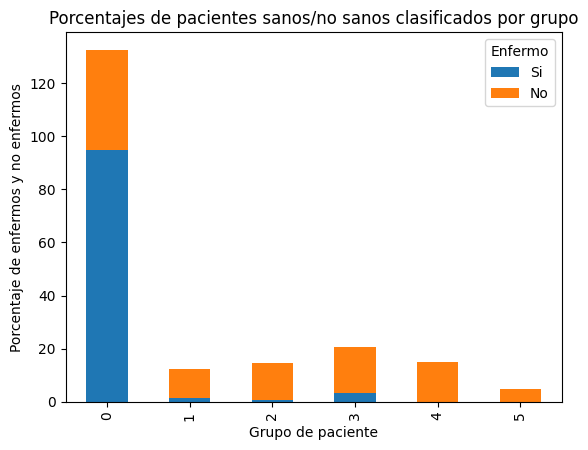

In [42]:
# Se muestra en un dataframe un histograma con los grupos existentes y el porcentaje que corresponden a pacientes enfermos
df_map2 = pd.DataFrame({ "Grupo": dbscan_umap.labels_, "Enfermo": y_data2} )
# Gráficos apilados
df_crosstab_umap = pd.crosstab(index=df_map2['Grupo'], columns=df_map2['Enfermo'])
df_crosstab_umap.rename(columns = {0: "Si", 1: "No"},inplace=True)
print("Tabla de frecuencias por grupo de pacientes")
print(df_crosstab_umap)

# Gráficos apilados
# Calculo el porcentaje a lo largo de las filas
df_crosstab_umap2 = df_crosstab_umap.apply(lambda r: r/r.sum() * 100,axis=0)
# Porcentaje de grupos
print("Tabla de frecuencias normalizada por grupo de pacientes")
print(df_crosstab_umap2)
# Visualizo resultados
ax = df_crosstab_umap2.plot(kind='bar', stacked=True)
plt.title("Porcentajes de pacientes sanos/no sanos clasificados por grupo")
ax.set_xlabel("Grupo de paciente")
ax.set_ylabel("Porcentaje de enfermos y no enfermos")


En este caso hay 6 grupos de pacientes, los pacientes enfermos se muestran de manera clara en el grupo 0; también hay una minoria de enfermos que 
se distribuyen en los grupos 3 y 4. Los pacientes sanos se distribuyen entre todos los grupos, siendo mas presentes en el grupo 0.
El 95% aproximadamente de los pacienes enfermos se situan en el grupo 0 y el 37 % de los pacientes sanos se situan en el resto de grupos.
La exactitud del modelo para la clasificación es del 75.55%.

In [43]:
# Calculo de los parámetros de la matriz de confusión adaptada 
indexs = {1,2,3,4,5,6}
PatN_TP = df_crosstab_umap["No"][1:6].sum()
PatN_FP = df_crosstab_umap["No"][0]

PatAbN_FP = df_crosstab_umap["Si"][1:6].sum()
PatAbN_TP = df_crosstab_umap["Si"][0] 

accuracy =  (PatAbN_TP + PatN_TP)  / (PatN_TP + PatN_FP + PatAbN_TP + PatAbN_FP) * 100
precision =  PatAbN_TP / (PatAbN_TP + PatAbN_FP) * 100
print ("% exactitud para clasificar pacientes en enfermos y no enfermos es de : " + str(round(accuracy,2)))
print ("% precision para clasificar pacientes en enfermos y no enfermos es de : " + str(round(precision,2)))

% exactitud para clasificar pacientes en enfermos y no enfermos es de : 75.55
% precision para clasificar pacientes en enfermos y no enfermos es de : 94.67


## 2.6  Autoencoder y DBSCAN para clasificación
En este apartado utilizaré un autoeconder extraido de una publicación  y que entrenaré con las imágenes disponibles.   
Después de entrenarlo haré una extracción de las características del bloque codificador para la tarea de caracterizar  
las imangenes apicando el algoritmo DBSCAN.  
Esta red convolucinal ha sido extraida de artículo publicado y ha sido adaptada a imagenes 224x224.  
Aquí hay una capa en la cual se obtiene un vector 1x1x512 con las características de la imagen directamente.  
Se ha modificado la capa conv5 para aplanar las características añadiendo un filtro 14x14 y se eliminado el padding en conv5 y conv6.

In [6]:
# Definición de la red a utilizar

# Bloque extractor
input1 = keras.Input(shape=(224,224,3))

# Convoluciones
conv1 = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input1)
maxp1 = MaxPooling2D(pool_size=(2, 2),strides=2)(conv1)

conv2 = Conv2D(64,kernel_size=(3,3),activation="relu", padding="same", kernel_initializer='he_normal')(maxp1)
maxp2 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv2)

conv3 = Conv2D(128,kernel_size=(3,3),activation="relu", padding="same", kernel_initializer='he_normal')(maxp2)
maxp3 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv3)

conv4 = Conv2D(256,kernel_size=(3,3),activation="relu", padding="same", kernel_initializer='he_normal')(maxp3)
maxp4 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv4)

# Capa flatten
conv5 = Conv2D(512,kernel_size=(14,14),activation="relu", padding="valid", 
               strides=1, name="encoderOut")(maxp4)
batNorm2 = BatchNormalization() (conv5)

# bloque decodificador
conv6 = Conv2DTranspose(256,kernel_size=(14,14),activation="relu", padding="valid")(batNorm2)
maxp6 = UpSampling2D(size=(2, 2), interpolation="nearest")(conv6)          

conv7 = Conv2DTranspose(128,kernel_size=(3,3),activation="relu", padding="same")(maxp6)
maxp7 = UpSampling2D (size=(2, 2), interpolation="nearest")(conv7)

conv8 = Conv2DTranspose(64,kernel_size=(3,3),activation="relu", padding="same",)(maxp7)
maxp8 = UpSampling2D (size=(2, 2), interpolation="nearest")(conv8)

conv9 = Conv2DTranspose(32,kernel_size=(3,3),activation="relu", padding="same",)(maxp8)
maxp9 = UpSampling2D (size=(2, 2), interpolation="nearest")(conv9)

conv10 = Conv2DTranspose(3,kernel_size=(3,3),activation="relu", padding="same",)(maxp9)

model_autoEnc = Model(inputs=input1, outputs=conv10, name="ModelAutoEncoder")

model_autoEnc.summary()

Model: "ModelAutoEncoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoderOut (Conv2D)             │ (None, 1, 1, 512)      │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 1, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 256)    │    25,690,368 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 56, 56, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 112, 112, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,159,619 (198.97 MB)

 Trainable params: 52,158,595 (198.97 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [7]:
# Compilació de la xarxa
model_autoEnc.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
 

In [8]:
# Entrenament de la xarxa
# Selecciono las imagenes de train y test para extraer sus caracteriticas

x_train, y_train = getImageInfo(train_data)
x_val, y_val = getImageInfo(val_data)
x_test, y_test = getImageInfo(test_data)

# Agrupo datos de training y test para entrenar
x_train_grup = np.concatenate([x_train, x_test], axis=0 )

# Normalización de los datos 
normalization_layer = Rescaling(1./255)
norm_train_auto = normalization_layer(x_train_grup)
# Validation
norm_val  = normalization_layer(x_val)
norm_val_auto = (norm_val,norm_val)

# Fit
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=10,
                                            mode='auto',
                                            restore_best_weights=True)

history2 = model_autoEnc.fit(x=norm_train_auto, y= norm_train_auto, epochs=100,
                             validation_data = norm_val_auto,                             
                             validation_freq=1,                             
                             shuffle=True,
                             initial_epoch=0)

Epoch 1/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 3:38 22s/step - loss: 0.0999

I0000 00:00:1716580198.084506      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 0.0723 - val_loss: 366.9377
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.0445 - val_loss: 43.8700
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0418 - val_loss: 30.6057
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0360 - val_loss: 20.7364
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0317 - val_loss: 17.1910
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0287 - val_loss: 10.3634
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0273 - val_loss: 5.1731
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0263 - val_loss: 2.1104
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0249 - val_loss: 1.0437
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0239 - val_loss: 1.2743
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.0254 - val_loss: 0.1921
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms

Ahora se hace una evaluación del modelo con los datos de test.

In [9]:
# Normalización de los datos de test
normalization_layer = Rescaling(1./255)
test_data_auto = normalization_layer(x_test)

In [10]:
# Evaluacion del ajuste del modelo
score = model_autoEnc.evaluate(test_data_auto,test_data_auto, verbose=0)
print("--> Loss: " + str(score))


--> Loss: 0.01643003709614277


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step


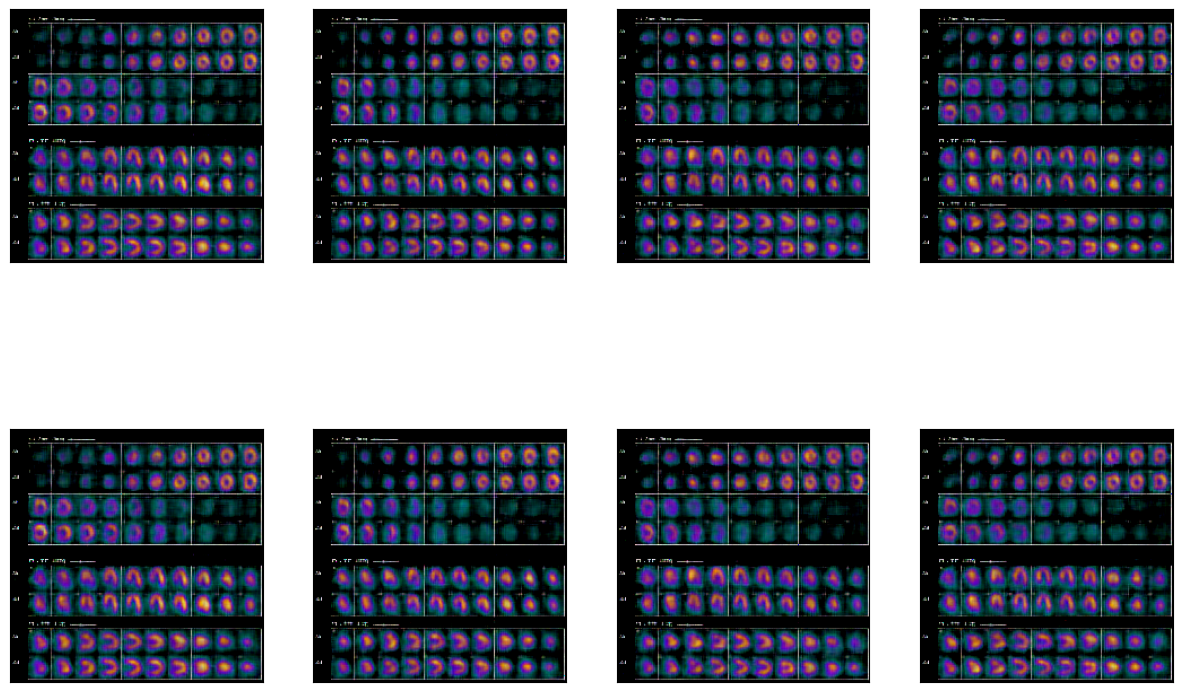

In [11]:
predit_batch = model_autoEnc.predict(test_data_auto)

predit_batch = predit_batch * 255
predit_batch = predit_batch.astype("uint8")

# Visualització
n = 4
fig, ax = plt.subplots(2, 4, figsize=(15,10))
for i in range(4):
    # mostrar la imagen original
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(predit_batch[i])                    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
       
    # mostrar la reconstrucción
    ax = plt.subplot(2, 4, i + 1 + n)
    plt.imshow(predit_batch[i])                
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    

Fase de extracción de características y encontrar agrupaciones

In [12]:
# Recupero la capa de entrenamiento de CNN
# Hasta la última capa convolucional
model_Encoder = Model(inputs = model_autoEnc.layers[1].input,
                      outputs = model_autoEnc.get_layer('encoderOut').output)                                

model_Encoder.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoderOut (Conv2D)             │ (None, 1, 1, 512)      │    25,690,624 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,079,040 (99.48 MB)

 Trainable params: 26,079,040 (99.48 MB)

 Non-trainable params: 0 (0.00 B)

Se extraen las características teniendo en cuenta los datos de train,validation y test.

In [13]:
#  Ahora se extraen las caracetrísticas de todas las muestras

# Agrupo datos de training y test
x_fit_grup = np.concatenate([x_train,x_val, x_test], axis=0 )
y_res_grup = np.concatenate([y_train,y_val, y_test], axis=0 )

numRecY = y_res_grup.shape[0]
y_res_grup2 = y_res_grup.reshape(numRecY,)

# Normalización de los datos 
normalization_layer = Rescaling(1./255)
norm_grup = normalization_layer(x_fit_grup)

img_features = model_Encoder.predict(norm_grup)
print ("Dimensión características : " + str(img_features.shape))

# Se generan vectores de características de las imagenes
shapeRec = img_features.shape
numRec = shapeRec[0]
lenRec = shapeRec[1]*shapeRec[2]*shapeRec[3]
features_array = np.reshape(img_features, (numRec,lenRec))

print ("La dimensión de los vectores de características son " + str(features_array.shape))


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Dimensión características : (364, 1, 1, 512)
La dimensión de los vectores de características son (364, 512)


Hago una reducción del espacio aplicando PCA

El número de elementos que contiene el 98% de la varianza es: 34


Text(0.5, 0, 'Numero de componentes')

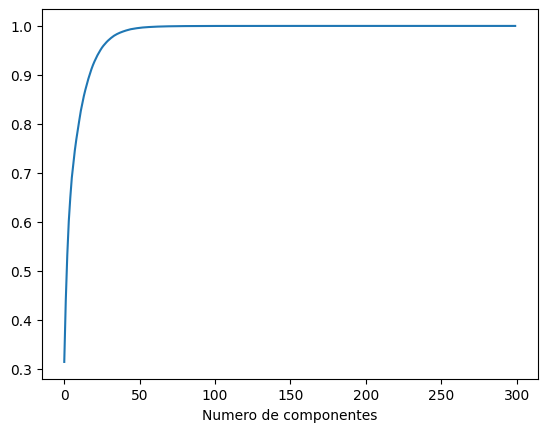

In [14]:
# Búsqueda de los componentes principales

from sklearn import manifold
from sklearn.decomposition import PCA

# Hago un estudio previo de cual pueden ser los componentes principales mas importantes.
pca = PCA(n_components=300)
pred_pca = pca.fit(features_array)

# Determino el conjunto de variables que explican como mínimo el 98% se la varianza
cumsum = np.cumsum(pca.explained_variance_ratio_)
limitcumsum = cumsum[cumsum <=0.98]
pcNumber = limitcumsum.shape[0]

print("El número de elementos que contiene el 98% de la varianza es: " + str(pcNumber))

# Visualizo la gráfica
plt.plot(cumsum)
plt.xlabel('Numero de componentes')

Utilizo los 16 primeros componentes principales

In [15]:
# Utilizo los primeros 34 componentes principales
pca = PCA(n_components=34)

# Los valores predichos
pred_pca = pca.fit_transform(features_array)
print("Shape despues de aplicar PCA {}".format(pred_pca.shape))

# Valores en formato de dataframe
feat_column_names = []
for i in range(pred_pca.shape[1]):
    feat_column_names.append('feature_{0}'.format(i+1))    
df_pred_pca = pd.DataFrame(pred_pca, columns = feat_column_names)
df_pred_pca.head()

Shape despues de aplicar PCA (364, 34)


feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  96.102257 -25.148815  -3.203768  21.487732  -3.252463  19.469006   
1  -6.778288 -11.199454  43.735840  11.701626 -62.203220  -9.655633   
2 -32.378677  14.407190  -3.569669   9.412555 -53.627502  19.581951   
3 -73.597839 -21.581535  56.859497 -18.377451  11.136990 -15.850307   
4 -29.382717   9.195214 -34.957764   2.480979 -38.687206  20.153194   

   feature_7  feature_8  feature_9  feature_10  ...  feature_25  feature_26  \
0   0.130255 -38.153534 -15.773921   20.954334  ...   -1.807269    1.730916   
1   9.707842  -5.163054  20.470928    4.756645  ...   31.241182  -15.730088   
2 -21.170874   3.841443  -0.467964    6.696624  ...    3.560307    4.449387   
3   0.478772  19.704870  13.347156  -12.643992  ...   -9.549744  -11.159647   
4   8.204665   5.661061  21.651457   12.063228  ...  -10.626987    3.046444   

   feature_27  feature_28  feature_29  feature_30  feature_31  feature_32  \
0   -9.187405   -6.711446   -4.930401    0.809392    3.553536    0.029974   
1  -10.433735  -18.240940   -0.861366  -15.525035   -9.687937   -6.967026   
2   -2.105331   -1.788519    2.196430   10.694415    4.124509   -4.374118   
3    0.468750   -9.939034  -12.956761   -5.438660    8.647415   -2.693623   
4   -1.151088    8.443151   -1.210589   -8.169107    3.186741    7.777488   

   feature_33  feature_34  
0    3.469381   -2.345267  
1   -4.043061   -3.507454  
2    0.659724    2.583955  
3   -8.041442    8.617161  
4   -0.983531   14.870636  

[5 rows x 34 columns]

Aquí aplico el agoritmo de UMAP:

In [17]:
import umap

umap_reducer = umap.UMAP(n_components = 34 ,n_neighbors=15, min_dist=0.1, metric='euclidean' )    
X_umap_reduced = umap_reducer.fit_transform(features_array)   

print(X_umap_reduced.shape)
print(y_res_grup.shape)


(364, 34)
(364, 1)


(364, 34)
(364, 1)


<Figure size 2500x2500 with 0 Axes>

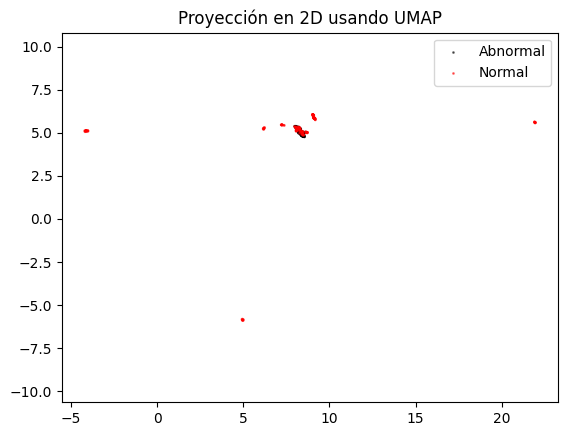

In [18]:
# Ahora hago la visualización con diferentes colores

colors = ['black','red']

print(X_umap_reduced.shape)
print(y_res_grup.shape)

plt.figure(figsize=(25, 25))
fig, ax = plt.subplots()

def readColors(y_colors):
    result= []
    for y_color in y_colors:
        result.append(colors[int(y_color)])        
    return result

#
mask = (y_res_grup2 == 0)    
colList = readColors(y_res_grup2[mask])    
plt.scatter(X_umap_reduced[mask,0],X_umap_reduced[mask,1], c=colList, label='Abnormal',alpha=0.5, s=1)    
#
mask = (y_res_grup2 == 1)    
colList = readColors(y_res_grup2[mask])    
plt.scatter(X_umap_reduced[mask,0],X_umap_reduced[mask,1], c=colList, label='Normal',alpha=0.5, s=1)    

ax.legend()
plt.title('Proyección en 2D usando UMAP');
plt.gca().set_aspect('equal', 'datalim')
plt.show()

In [19]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Determino los vectores máximo y mínimo de las características para calcular la distancia máxima de dos puntos
pred_pca_max = np.amax(X_umap_reduced, axis = 0)
pred_pca_min = np.amin(X_umap_reduced, axis = 0)
dist = np.linalg.norm(pred_pca_max - pred_pca_min)
print("La distancia máxima entre dos puntos es :" + str(dist))

# Se crea DBSCAN jugando con los parámetros epsilon
# eps = the maximum distance between two samples for one to be considered as in the neighborhood of the other
num_clusters = []
eps_values =[]
for i in np.arange(0.001,2.5,0.1):
    dbscan = DBSCAN(eps=i, min_samples=5)
    dbscan.fit(X_umap_reduced)    
    ngrups = len(np.unique(dbscan.labels_, return_counts=False))
    noClasif= len(dbscan.labels_[dbscan.labels_<0])     
    # Visualizo resultado
    print("Epsilon=" + str(i) + "; No clasificados=" + str(noClasif) + "; Número de grupos=" +str(ngrups))    
    # Guardo la información del numero de clusters y resto 1 si no clasificados
    num_clusters.append((ngrups,noClasif) )        
    eps_values.append(i)

La distancia máxima entre dos puntos es :43.595093
Epsilon=0.001; No clasificados=364; Número de grupos=1
Epsilon=0.101; No clasificados=343; Número de grupos=5
Epsilon=0.201; No clasificados=245; Número de grupos=16
Epsilon=0.30100000000000005; No clasificados=170; Número de grupos=20
Epsilon=0.401; No clasificados=80; Número de grupos=22
Epsilon=0.501; No clasificados=15; Número de grupos=12
Epsilon=0.6010000000000001; No clasificados=1; Número de grupos=11
Epsilon=0.7010000000000001; No clasificados=0; Número de grupos=10
Epsilon=0.801; No clasificados=0; Número de grupos=10
Epsilon=0.901; No clasificados=0; Número de grupos=9
Epsilon=1.001; No clasificados=0; Número de grupos=9
Epsilon=1.101; No clasificados=0; Número de grupos=9
Epsilon=1.201; No clasificados=0; Número de grupos=9
Epsilon=1.301; No clasificados=0; Número de grupos=8
Epsilon=1.401; No clasificados=0; Número de grupos=8
Epsilon=1.501; No clasificados=0; Número de grupos=8
Epsilon=1.601; No clasificados=0; Número de 

Hago las agrupaciones

In [20]:
dbscan_decod = DBSCAN(eps=0.701, min_samples=5)
dbscan_decod.fit(X_umap_reduced)

DBSCAN(eps=0.701)

Miro el histograma de la clasificación final

Tabla de frecuencias por grupo de pacientes
Enfermo   Si  No
Grupo           
0          0  44
1        149  58
2          0  11
3          0   9
4          0  20
5          0  20
6          0  16
7          0  10
8          0  10
9          1  16
Tabla de frecuencias normalizada por grupo de pacientes
Enfermo         Si         No
Grupo                        
0         0.000000  20.560748
1        99.333333  27.102804
2         0.000000   5.140187
3         0.000000   4.205607
4         0.000000   9.345794
5         0.000000   9.345794
6         0.000000   7.476636
7         0.000000   4.672897
8         0.000000   4.672897
9         0.666667   7.476636


Text(0, 0.5, 'Porcentaje de enfermos y no enfermos')

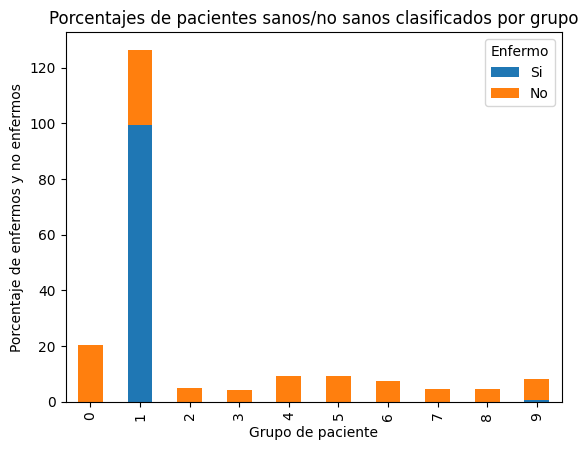

In [21]:

# Se muestra en un dataframe un histograma con los grupos existentes y el porcentaje que corresponden a pacientes enfermos

numRecY = y_res_grup.shape[0]
y_data2 = y_res_grup.reshape(numRecY,)

df_map3 = pd.DataFrame({ "Grupo": dbscan_decod.labels_, "Enfermo": y_data2} )
# Gráficos apilados
df_crosstab_umap = pd.crosstab(index=df_map3['Grupo'], columns=df_map3['Enfermo'])
df_crosstab_umap.rename(columns = {0: "Si", 1: "No"},inplace=True)
print("Tabla de frecuencias por grupo de pacientes")
print(df_crosstab_umap)

# Gráficos apilados
# Calculo el porcentaje a lo largo de las filas
df_crosstab_umap2 = df_crosstab_umap.apply(lambda r: r/r.sum() * 100,axis=0)
# Porcentaje de grupos
print("Tabla de frecuencias normalizada por grupo de pacientes")
print(df_crosstab_umap2)
# Visualizo resultados
ax = df_crosstab_umap2.plot(kind='bar', stacked=True)
plt.title("Porcentajes de pacientes sanos/no sanos clasificados por grupo")
ax.set_xlabel("Grupo de paciente")
ax.set_ylabel("Porcentaje de enfermos y no enfermos")


Vamos a mirar la exactitud de este modelo

In [22]:
# Calculo de los parámetros de la matriz de confusión adaptada 
 
PatN_TP = df_crosstab_umap["No"][0].sum() + df_crosstab_umap["No"][2:8].sum()
PatN_FP = df_crosstab_umap["No"][1]

PatAbN_TP = df_crosstab_umap["Si"][1] 
PatAbN_FP = df_crosstab_umap["Si"][0].sum() + df_crosstab_umap["Si"][2:8].sum()


accuracy =  ((PatAbN_TP + PatN_TP)  / (PatN_TP + PatN_FP + PatAbN_TP + PatAbN_FP))* 100
precision =  PatAbN_TP / (PatAbN_TP + PatAbN_FP) * 100

print ("Exactitud: " + str(round(accuracy,2)) + "%")
print ("Precision: " + str(round(precision,2)) + "%")

Exactitud: 82.79%
Precision: 100.0%
